In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences # to pad sequences

from sklearn.preprocessing import StandardScaler # to normalise data
from sklearn.metrics import mean_squared_error

2023-05-01 22:14:40.631793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 22:14:40.753129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 22:14:40.753149: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-01 22:14:41.554722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [27]:
#========================#
# DEPENDENCIES           #
#========================#
# print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
# pandas==1.5.3
# numpy==1.24.1
# tensorflow==2.11.0
# keras.api._v2.keras==2.11.0

pandas==1.5.3
numpy==1.24.1
tensorflow==2.11.0
keras.api._v2.keras==2.11.0


In [28]:
cwd = os.getcwd()
print(cwd)

# change working directory if needed
# DIR = "set working directory here"
# os.chdir(DIR)

In [3]:
#========================#
# LOAD DATA              #
#========================#
#
# Variable Names:
# train_data
# test_data
#

# load each fold as dictionary
def load_data_with_folds(scenario_dir_path, dataset_type):
    # make dict to store data frames for each fold
    fold_dfs = {}
    # iterate over the scenario directory
    for fold_dir in Path(scenario_dir_path).iterdir():
        if fold_dir.name.startswith('.'):
            continue  # skip hidden files/folders like .DS_Store and .ipynb_checkpoints
        train_annotations_dir = Path(fold_dir, f"{dataset_type}/annotations/")
        train_physiology_dir = Path(fold_dir, f"{dataset_type}/physiology/")
        train_physiology_files = sorted(p for p in Path(train_physiology_dir).iterdir() if not p.name.startswith('.'))
        train_annotation_files = sorted(p for p in Path(train_annotations_dir).iterdir() if not p.name.startswith('.'))
        fold_df = pd.DataFrame()
        for physiology_file_path, annotations_file_path in zip(train_physiology_files, train_annotation_files):
            if physiology_file_path.name.startswith('.') or annotations_file_path.name.startswith('.'):
                continue  # skip hidden files like .DS_Store and .ipynb_checkpoints
            assert physiology_file_path.name == annotations_file_path.name, "Order mismatch"
            df_physiology = pd.read_csv(physiology_file_path)
            df_annotations = pd.read_csv(annotations_file_path)
            subject = annotations_file_path.name
            merged_df = pd.merge(df_physiology, df_annotations, on="time", how="outer")
            merged_df["subject"] = [subject] * len(merged_df)
            fold_df = pd.concat([fold_df, merged_df], ignore_index=True)
        fold_dfs[fold_dir.name] = fold_df
    return fold_dfs

# specify scenario path
scenario_dir = "data/scenario_3"

# train data
print("Loading train data")
train_data = load_data_with_folds(scenario_dir, "train")

# test data
print("Loading test data")
test_data = load_data_with_folds(scenario_dir, "test")


Loading train data
Loading test data


In [4]:
# check data was loaded
print(sorted(train_data.keys()))
print(sorted(test_data.keys()))

for key, df in train_data.items():
    print(f"{key}:\n")
    display(df)
    print(f"The max time: {df['time'].max()}")

['fold_0', 'fold_1', 'fold_2', 'fold_3']
['fold_0', 'fold_1', 'fold_2', 'fold_3']
fold_0:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,1.280,36.873,39.288,34.405,26.785,5.440,5.563,7.124,5.000,5.000,sub_0_vid_0.csv
1,1,1.273,37.009,39.292,34.424,26.792,5.399,5.604,7.205,NaN,NaN,sub_0_vid_0.csv
2,2,1.260,37.029,39.288,34.424,26.795,5.440,5.645,7.165,NaN,NaN,sub_0_vid_0.csv
3,3,1.260,36.646,39.374,34.434,26.795,5.440,5.564,7.165,NaN,NaN,sub_0_vid_0.csv
4,4,1.260,36.757,39.320,34.396,26.785,5.277,5.441,7.124,NaN,NaN,sub_0_vid_0.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
15808275,79696,0.803,36.895,30.540,34.270,26.707,5.400,9.751,21.743,NaN,NaN,sub_8_vid_4.csv
15808276,79697,0.823,37.019,30.520,34.289,26.718,5.480,9.793,21.825,NaN,NaN,sub_8_vid_4.csv
15808277,79698,0.813,37.125,30.488,34.289,26.711,5.481,9.834,21.826,NaN,NaN,sub_8_vid_4.csv
15808278,79699,0.813,36.887,30.418,34.270,26.708,5.400,9.916,21.745,NaN,NaN,sub_8_vid_4.csv


The max time: 118550
fold_1:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,0.862,36.398,11.035,32.246,27.528,5.193,5.892,8.807,5.000,5.000,sub_0_vid_10.csv
1,1,0.849,36.477,11.024,32.218,27.514,5.072,5.851,8.767,NaN,NaN,sub_0_vid_10.csv
2,2,0.849,36.084,11.016,32.237,27.521,5.152,5.932,8.807,NaN,NaN,sub_0_vid_10.csv
3,3,0.862,36.186,11.063,32.227,27.521,5.193,5.811,8.767,NaN,NaN,sub_0_vid_10.csv
4,4,0.866,36.292,11.071,32.237,27.521,5.153,5.891,8.807,NaN,NaN,sub_0_vid_10.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
15271101,79696,0.803,36.895,30.540,34.270,26.707,5.400,9.751,21.743,NaN,NaN,sub_8_vid_4.csv
15271102,79697,0.823,37.019,30.520,34.289,26.718,5.480,9.793,21.825,NaN,NaN,sub_8_vid_4.csv
15271103,79698,0.813,37.125,30.488,34.289,26.711,5.481,9.834,21.826,NaN,NaN,sub_8_vid_4.csv
15271104,79699,0.813,36.887,30.418,34.270,26.708,5.400,9.916,21.745,NaN,NaN,sub_8_vid_4.csv


The max time: 129949
fold_2:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,1.280,36.873,39.288,34.405,26.785,5.440,5.563,7.124,5.000,5.000,sub_0_vid_0.csv
1,1,1.273,37.009,39.292,34.424,26.792,5.399,5.604,7.205,NaN,NaN,sub_0_vid_0.csv
2,2,1.260,37.029,39.288,34.424,26.795,5.440,5.645,7.165,NaN,NaN,sub_0_vid_0.csv
3,3,1.260,36.646,39.374,34.434,26.795,5.440,5.564,7.165,NaN,NaN,sub_0_vid_0.csv
4,4,1.260,36.757,39.320,34.396,26.785,5.277,5.441,7.124,NaN,NaN,sub_0_vid_0.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
17667851,79696,0.803,36.895,30.540,34.270,26.707,5.400,9.751,21.743,NaN,NaN,sub_8_vid_4.csv
17667852,79697,0.823,37.019,30.520,34.289,26.718,5.480,9.793,21.825,NaN,NaN,sub_8_vid_4.csv
17667853,79698,0.813,37.125,30.488,34.289,26.711,5.481,9.834,21.826,NaN,NaN,sub_8_vid_4.csv
17667854,79699,0.813,36.887,30.418,34.270,26.708,5.400,9.916,21.745,NaN,NaN,sub_8_vid_4.csv


The max time: 129949
fold_3:



,time,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,valence,arousal,subject
0,0,1.280,36.873,39.288,34.405,26.785,5.440,5.563,7.124,5.0,5.000,sub_0_vid_0.csv
1,1,1.273,37.009,39.292,34.424,26.792,5.399,5.604,7.205,NaN,NaN,sub_0_vid_0.csv
2,2,1.260,37.029,39.288,34.424,26.795,5.440,5.645,7.165,NaN,NaN,sub_0_vid_0.csv
3,3,1.260,36.646,39.374,34.434,26.795,5.440,5.564,7.165,NaN,NaN,sub_0_vid_0.csv
4,4,1.260,36.757,39.320,34.396,26.785,5.277,5.441,7.124,NaN,NaN,sub_0_vid_0.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
17275001,106046,0.787,37.765,18.345,34.850,26.182,5.645,6.138,18.670,NaN,NaN,sub_8_vid_3.csv
17275002,106047,0.787,37.766,18.384,34.802,26.182,5.523,6.098,18.176,NaN,NaN,sub_8_vid_3.csv
17275003,106048,0.774,37.919,18.420,34.792,26.178,5.685,6.138,17.561,NaN,NaN,sub_8_vid_3.csv
17275004,106049,0.767,38.016,18.455,34.792,26.178,5.605,6.138,17.067,NaN,NaN,sub_8_vid_3.csv


The max time: 129949


In [13]:
#====================================#
# PAD VIDEO SEQUENCES: TRAINING SET  #
#====================================#
#
# Variable Names:
# train_data_scaled_padded
# test_data_scaled_padded
#

# set maxlen so that it is in increments of 50 to match the affect timescales
maxlen = 132000 

# separate out each video sequence, in prep for padding
train_data_scaled_padded = {}

# loop through each fold
for key, df in train_data.items():
    
    # find start of each sequence
    idx_zero = np.where(df['time']==0)[0]

    # initialize lists to store the data
    valence = []
    arousal = []
    raw_data = []

    # loop through each video sequence in the fold
    for i in range(len(idx_zero)):
        
        if i == len(idx_zero) - 1:
            
            valence.append(df['valence'][idx_zero[i]:])
            arousal.append(df['arousal'][idx_zero[i]:])
            raw_data.append(df.iloc[idx_zero[i]:, 1:9])
            
        else:
            
            valence.append(df['valence'][idx_zero[i]:idx_zero[i+1]])
            arousal.append(df['arousal'][idx_zero[i]:idx_zero[i+1]])
            raw_data.append(df.iloc[idx_zero[i]:idx_zero[i+1], 1:9])

    # store in each fold in dictionary
    train_data_scaled_padded[key] = {
        'valence': np.array(valence, dtype=object),
        'arousal': np.array(arousal, dtype=object),
        'raw_data': np.array(raw_data, dtype=object)
    }

# pad train data sequences to make them equal length
for key, array in train_data_scaled_padded.items():
    
    array['valence'] = pad_sequences(valence, dtype="float64", maxlen=maxlen, value=0.0, padding="post")
    array['arousal'] = pad_sequences(arousal, dtype="float64", maxlen=maxlen, value=0.0, padding="post")
    array['raw_data'] = pad_sequences(raw_data, dtype="float64", maxlen=maxlen, value=0.0, padding="post")

# check shape after padding
for key, array in train_data_scaled_padded.items():  
    
    print(array['valence'].shape)
    print(array['arousal'].shape)
    print(array['raw_data'].shape)
    break
    
for seq in array['valence']:
    length = len(seq)
    print(f"Length of sequence: {length}")
    break

(180, 132000)
(180, 132000)
(180, 132000, 8)
Length of sequence: 132000


In [14]:
# reshape data to prepare for timeseries batching
for key, array in train_data_scaled_padded.items():
    array['valence'] = array['valence'].reshape(-1)
    array['arousal'] = array['arousal'].reshape(-1)
    array['raw_data'] = array['raw_data'].reshape(-1, 8)
    
# check shape again
for key, array in train_data_scaled_padded.items():  
    print(array['valence'].shape)
    print(array['arousal'].shape)
    print(array['raw_data'].shape)
    break



(23760000,)
(23760000,)
(23760000, 8)


In [15]:
# stack valence and arousal & transpose
for key, array in train_data_scaled_padded.items(): 
    array['affect'] = np.vstack((array['valence'], array['arousal'])).T
    print(array['affect'].shape)

(23760000, 2)
(23760000, 2)
(23760000, 2)
(23760000, 2)


In [17]:
#================================#
# PAD VIDEO SEQUENCES: TEST SET  #
#================================#


# pad test data
test_data_scaled_padded = {}

# loop through each fold
for key, df in test_data.items():
    
    # find start of each video sequence
    idx_start = np.where(df['time']==9900)[0] # only keep buffer of 100ms prior
    idx_end = np.where(df['time']==40000)[0]

    # initialize lists to store the data
    raw_data = []

    # loop through each sequence in fold
    for i in range(len(idx_start)): # n_videos
        
        raw_data.append(df.iloc[idx_start[i]:idx_end[i], 1:9])

    # store in each fold in dictionary
    test_data_scaled_padded[key] = {
        'raw_data': np.array(raw_data, dtype=object)
    }

# pad test data sequences
for key, array in test_data_scaled_padded.items():
    array['raw_data'] = pad_sequences(raw_data, dtype="float64", maxlen=30100, value=0.0, padding="post")
    array['raw_data'] = array['raw_data'].reshape(-1, 8)

# check shape after padding
for key, array in test_data_scaled_padded.items():  
    
    print(array['raw_data'].shape)
    break



(1806000, 8)


In [19]:
#================================#
# SPLIT INTO TIMESERIES BATCHES  #
#================================#
#
# Variable Names:
# train_dataset
# test_dataset
#

# split into timeseries batches for train, test
# using keras timeseries_dataset_from_array

sequence_length = 100 # 100ms windows
sampling_rate = 1 # sampling rate within a sequence
sequence_stride = 50 # how much to shift window by
delay = sequence_length # target is N+delay

train_dataset = {}
test_dataset = {}

for key, array in train_data_scaled_padded.items():
    
    train_dataset[key] = keras.utils.timeseries_dataset_from_array(
        data=array['raw_data'],
        targets= array['affect'],
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        sampling_rate=sampling_rate,
        batch_size=2640, # number of sequences per batch,
        shuffle=False,
        )
    
    
    
for key, array in test_data_scaled_padded.items():
    
    test_dataset[key] = keras.utils.timeseries_dataset_from_array(
        data=array['raw_data'],
        targets=None, 
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        sampling_rate=sampling_rate,
        batch_size=610,
        shuffle=False,
        )


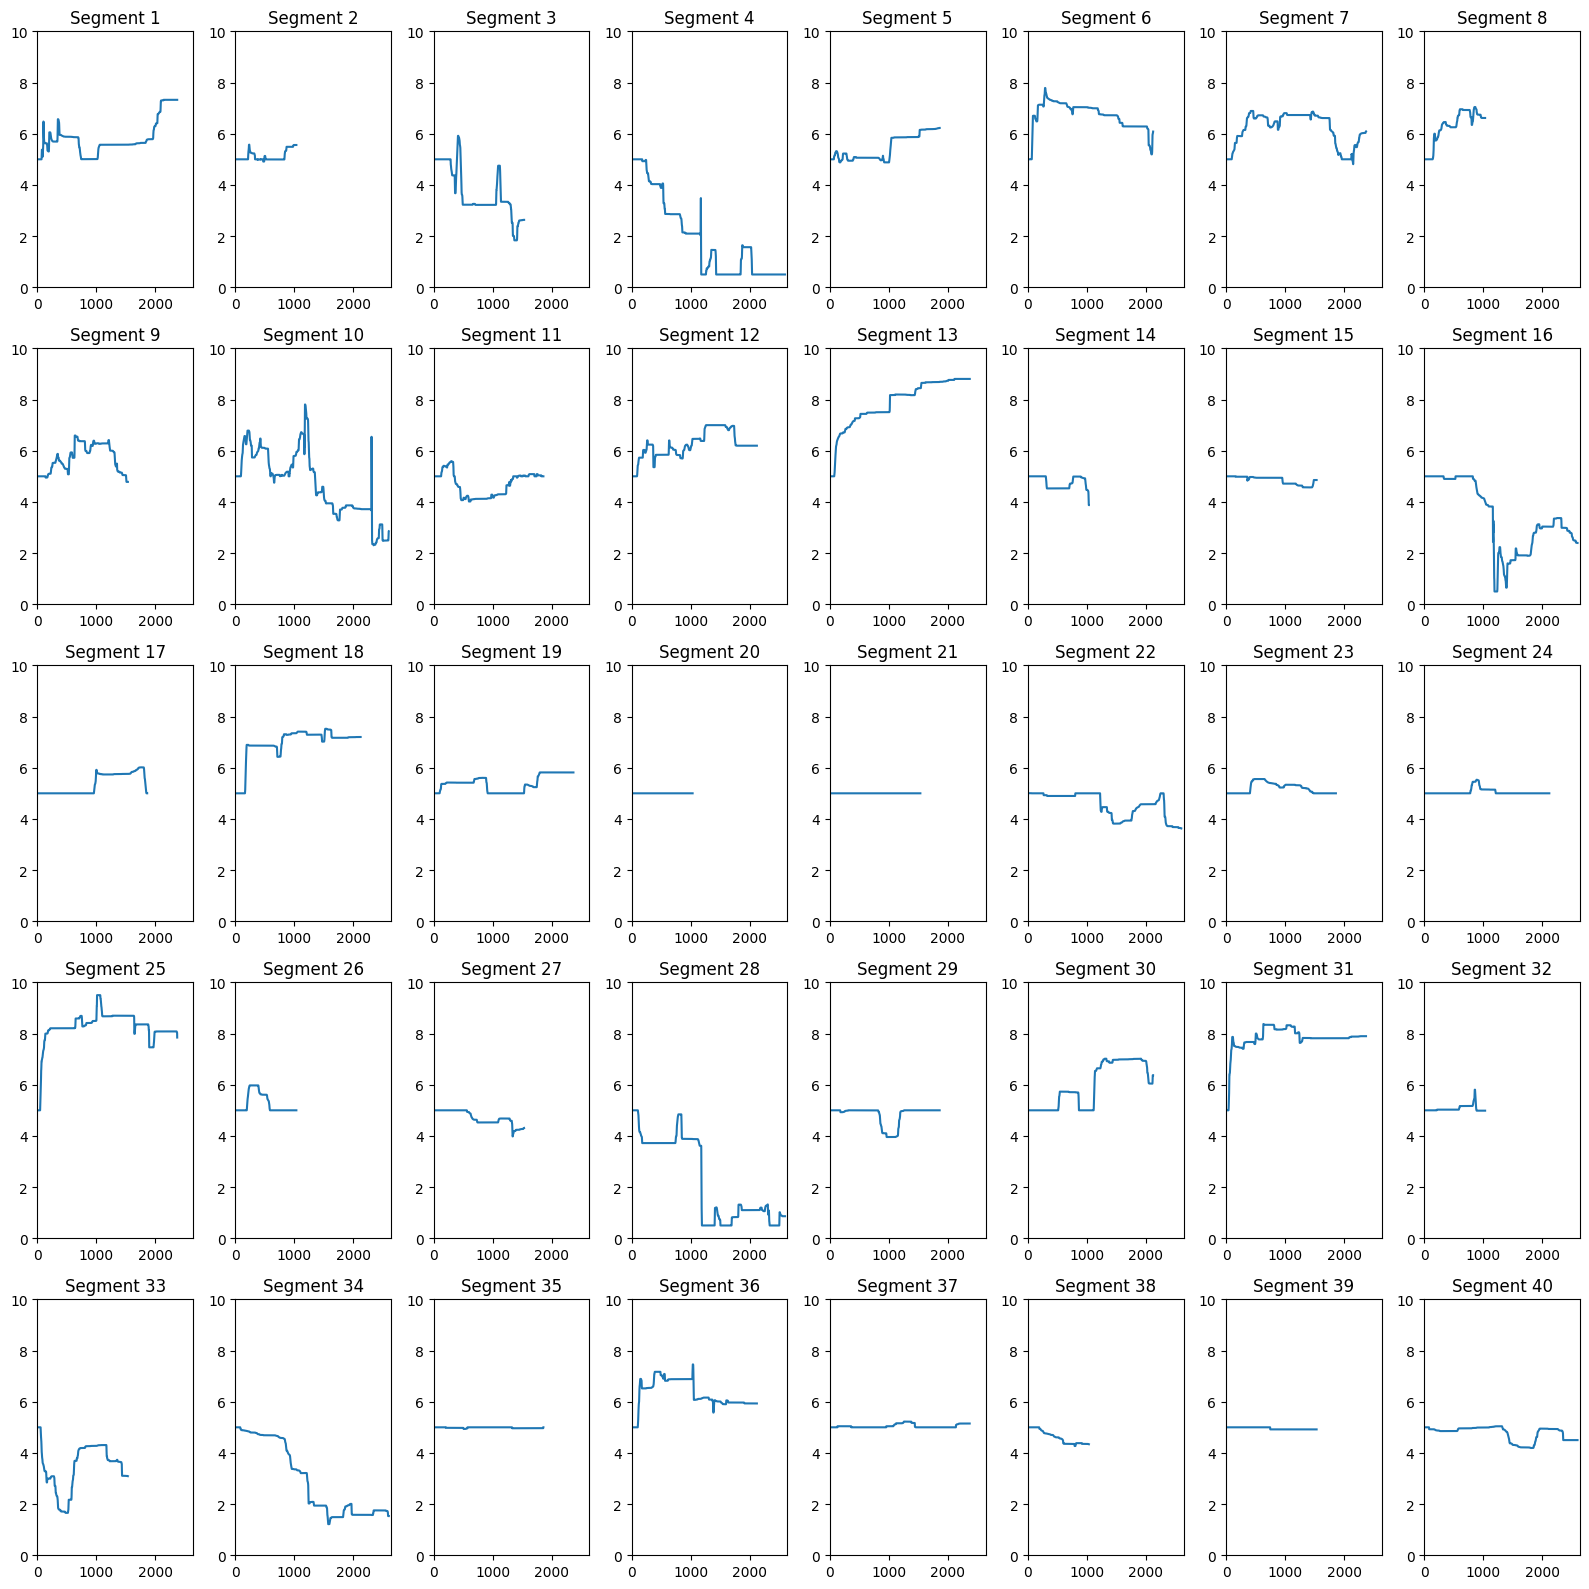

In [20]:
# check that the padded sequences are correct 
# plot valence ratings of 8 videos for first 5 subjects

import matplotlib.pyplot as plt

one_vid = maxlen

fig, axs = plt.subplots(nrows=5, ncols=8, figsize=(16, 16))

for key, array in train_data_scaled_padded.items():
    for i in range(40):
        row = i // 8
        col = i % 8
        start_idx = i * one_vid
        end_idx = (i + 1) * one_vid
        # filter out 0 values
        valence_data = array['valence'][start_idx:end_idx:50]
        valence_data = valence_data[valence_data != 0]
        axs[row, col].plot(valence_data)
        axs[row, col].set_title(f'Segment {i+1}')
        axs[row, col].set_ylim([0, 10])
        axs[row, col].set_xlim([0, maxlen/50])

    plt.tight_layout()
    plt.show()
    break

In [21]:
#========================#
# MODEL TRAINING: LSTM   #
#========================#

# for reproducibility
tf.random.set_seed(1)

# train one model per fold
for key in sorted(train_dataset.keys()):
    print(f"Training fold: {key}")
    
    # build model
    inputs = keras.Input(shape=(100, 8))
    x = layers.Masking(mask_value=0., input_shape=(100, 8))(inputs)
    x = layers.LSTM(128, recurrent_dropout=0.25)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(2, activation="linear")(x)
    model = keras.Model(inputs, outputs)
    
    model_name = f"scen3_model_{key}.h5"
    print(f"Training model: {model_name}")
    
    # compile
    model.compile(optimizer="rmsprop",
                  loss="mse")
    
    # train
    model.fit(train_dataset[key],
              epochs=10,
              shuffle=False,
              verbose=1,
             )
    
    # save
    model.save(model_name)
    
    # reset for next fold
    model.reset_states()
    tf.keras.backend.clear_session()
    

Training fold: fold_0
Training model: scen3_model_fold_0.h5
Epoch 1/10
180/180 [==============================] - 161s 882ms/step - loss: 9.9178
Epoch 2/10
180/180 [==============================] - 159s 884ms/step - loss: 3.0485
Epoch 3/10
180/180 [==============================] - 158s 878ms/step - loss: 2.9152
Epoch 4/10
180/180 [==============================] - 157s 872ms/step - loss: 2.8954
Epoch 5/10
180/180 [==============================] - 157s 869ms/step - loss: 2.8791
Epoch 6/10
180/180 [==============================] - 154s 854ms/step - loss: 2.8731
Epoch 7/10
180/180 [==============================] - 156s 867ms/step - loss: 2.8602
Epoch 8/10
180/180 [==============================] - 157s 870ms/step - loss: 2.8506
Epoch 9/10
180/180 [==============================] - 157s 870ms/step - loss: 2.8543
Epoch 10/10
180/180 [==============================] - 155s 863ms/step - loss: 2.8499
Training fold: fold_1
Training model: scen3_model_fold_1.h5
Epoch 1/10
180/180 [=========

In [29]:
# Define a dictionary to store predictions
all_preds = {}

# Loop through each model
for i in range(4):
    # Load the model
    model = keras.models.load_model(f'scen3_model_fold_{i}.h5')
    # Get predictions for the test data using the loaded model
    preds = model.predict(test_dataset[f'fold_{i}'])
    # Add the predictions to the dictionary with the key 'fold_i'
    all_preds[f'fold_{i}'] = preds
    



60/60 [==============================] - 5s 87ms/step


In [25]:
# generate and save predictions as csv files

num_iterations = 60 # 60 test files
num_preds = 601 # number of predictions per file

# loop through each fold
for key, preds in sorted(all_preds.items()):
    print(key)
    print(len(preds))
    
    # save predictions
    valence = all_preds[key][:, 0:1]
    arousal = all_preds[key][:, 1:2]
    print(len(valence))
    
    # set directory file path
    directory = f"results/scenario_3/{key}/test/annotations/"
    
    # create directory if not exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # loop through each test file and save
    for i in range(num_iterations):
        
        print(i)
        # get file name and set file path
        f = test_data[key][test_data[key]['time'] == 10000]['subject'].iloc[i]
        file_name = f"{f}"
        file_path = os.path.join(directory, file_name)
        
        # create time column
        df = pd.DataFrame({'time': np.arange(10000, 40000+1, 50)})
        
        start_index = (num_preds)*i
        end_index = (num_preds)*(i+1)
        
        # add in predictions
        df['valence'] = valence[start_index:end_index]
        df['arousal'] = arousal[start_index:end_index]
        
        display(df)
        
        # save df as csv
        df.to_csv(file_path, index=False)
        print(f"Saved: {file_path}")
    


    

fold_0
36119
36119
0


,time,valence,arousal
0,10000,4.671240,5.262696
1,10050,4.680022,5.268097
2,10100,4.651138,5.278230
3,10150,4.574183,5.277250
4,10200,4.640725,5.349938
...,...,...,...
596,39800,4.320549,5.291303
597,39850,4.461381,5.340307
598,39900,4.495461,5.374695
599,39950,4.552766,5.027164


Saved: results/scenario_3/fold_0/test/annotations/sub_0_vid_16.csv
1


,time,valence,arousal
0,10000,5.062910,4.982385
1,10050,4.907019,5.002146
2,10100,4.850062,5.070342
3,10150,4.857846,5.044756
4,10200,4.902336,5.060688
...,...,...,...
596,39800,4.634168,4.947580
597,39850,4.490300,4.914934
598,39900,4.411623,4.951043
599,39950,4.332716,4.931819


Saved: results/scenario_3/fold_0/test/annotations/sub_0_vid_20.csv
2


,time,valence,arousal
0,10000,4.506333,4.975963
1,10050,6.109020,4.351392
2,10100,5.904641,4.374258
3,10150,6.024575,4.372822
4,10200,6.122274,4.194568
...,...,...,...
596,39800,5.608265,4.646578
597,39850,5.628048,4.636335
598,39900,5.504165,4.655126
599,39950,5.599449,4.619112


Saved: results/scenario_3/fold_0/test/annotations/sub_10_vid_16.csv
3


,time,valence,arousal
0,10000,5.637143,4.615620
1,10050,5.666257,4.596961
2,10100,2.571356,6.965520
3,10150,2.813676,6.669950
4,10200,2.848004,6.715000
...,...,...,...
596,39800,2.888362,6.423568
597,39850,2.888425,6.408623
598,39900,2.969230,6.387310
599,39950,2.931075,6.409665


Saved: results/scenario_3/fold_0/test/annotations/sub_10_vid_20.csv
4


,time,valence,arousal
0,10000,2.917576,6.436812
1,10050,2.942145,6.488640
2,10100,2.926935,6.455531
3,10150,3.748892,5.587208
4,10200,3.551307,5.900610
...,...,...,...
596,39800,3.592410,5.676852
597,39850,3.633890,5.666106
598,39900,3.632898,5.700570
599,39950,3.627309,5.678043


Saved: results/scenario_3/fold_0/test/annotations/sub_11_vid_16.csv
5


,time,valence,arousal
0,10000,3.597280,5.684015
1,10050,3.565132,5.695355
2,10100,3.770234,6.027790
3,10150,3.663810,5.676588
4,10200,3.979482,5.734690
...,...,...,...
596,39800,3.807252,5.936780
597,39850,3.830006,5.883837
598,39900,3.810846,5.908900
599,39950,3.828412,5.937205


Saved: results/scenario_3/fold_0/test/annotations/sub_11_vid_20.csv
6


,time,valence,arousal
0,10000,3.782352,5.984279
1,10050,3.774813,5.965794
2,10100,3.796112,5.993304
3,10150,3.844226,5.970610
4,10200,4.085447,6.370545
...,...,...,...
596,39800,2.482774,7.188409
597,39850,2.597111,7.195391
598,39900,2.584379,7.055228
599,39950,2.523816,7.061384


Saved: results/scenario_3/fold_0/test/annotations/sub_13_vid_16.csv
7


,time,valence,arousal
0,10000,2.367795,7.233858
1,10050,2.201470,7.224840
2,10100,2.243356,7.203046
3,10150,2.320940,7.183937
4,10200,2.355570,7.174593
...,...,...,...
596,39800,3.182431,6.303655
597,39850,3.178626,6.230941
598,39900,3.197481,6.329385
599,39950,3.164039,6.297752


Saved: results/scenario_3/fold_0/test/annotations/sub_13_vid_20.csv
8


,time,valence,arousal
0,10000,3.193299,6.328182
1,10050,3.308009,6.378322
2,10100,3.283563,6.345374
3,10150,3.238011,6.308682
4,10200,3.289171,6.314841
...,...,...,...
596,39800,6.662318,4.942248
597,39850,6.429145,4.969776
598,39900,6.576481,5.007855
599,39950,6.651471,4.942813


Saved: results/scenario_3/fold_0/test/annotations/sub_14_vid_16.csv
9


,time,valence,arousal
0,10000,6.580503,4.933228
1,10050,6.587570,4.980377
2,10100,6.600587,4.966866
3,10150,6.529850,4.962392
4,10200,6.535926,4.948333
...,...,...,...
596,39800,7.472836,4.757739
597,39850,7.567533,4.819394
598,39900,7.502801,4.738198
599,39950,7.414062,4.692739


Saved: results/scenario_3/fold_0/test/annotations/sub_14_vid_20.csv
10


,time,valence,arousal
0,10000,7.509524,4.730936
1,10050,7.558228,4.775199
2,10100,7.546318,4.762866
3,10150,7.506160,4.737612
4,10200,7.479306,4.719217
...,...,...,...
596,39800,5.103472,5.167171
597,39850,5.357636,5.805303
598,39900,5.140429,5.237354
599,39950,5.529457,6.290574


Saved: results/scenario_3/fold_0/test/annotations/sub_15_vid_16.csv
11


,time,valence,arousal
0,10000,5.037081,5.190215
1,10050,5.300539,5.502174
2,10100,5.095756,5.184700
3,10150,5.337723,5.766798
4,10200,5.112045,5.174750
...,...,...,...
596,39800,3.615833,6.362797
597,39850,3.616052,6.356451
598,39900,3.607514,6.348696
599,39950,3.578688,6.356434


Saved: results/scenario_3/fold_0/test/annotations/sub_15_vid_20.csv
12


,time,valence,arousal
0,10000,3.557264,6.331247
1,10050,3.564522,6.323030
2,10100,3.587084,6.321814
3,10150,3.457552,6.341073
4,10200,3.198912,6.375020
...,...,...,...
596,39800,6.369401,5.863876
597,39850,6.462052,5.880373
598,39900,6.361979,5.932070
599,39950,6.407640,5.800463


Saved: results/scenario_3/fold_0/test/annotations/sub_16_vid_16.csv
13


,time,valence,arousal
0,10000,6.308698,5.906222
1,10050,6.310583,5.865368
2,10100,6.414814,5.887168
3,10150,6.339561,5.939226
4,10200,6.302241,5.882924
...,...,...,...
596,39800,6.371098,5.903309
597,39850,6.308134,5.964530
598,39900,6.315703,5.837454
599,39950,6.246276,5.962289


Saved: results/scenario_3/fold_0/test/annotations/sub_16_vid_20.csv
14


,time,valence,arousal
0,10000,6.303673,6.014987
1,10050,6.386784,5.834182
2,10100,6.289704,5.892682
3,10150,6.342741,5.853004
4,10200,6.328975,5.859618
...,...,...,...
596,39800,3.118124,6.074200
597,39850,3.209263,6.070580
598,39900,3.121333,6.080507
599,39950,3.113129,6.127127


Saved: results/scenario_3/fold_0/test/annotations/sub_17_vid_16.csv
15


,time,valence,arousal
0,10000,2.976140,6.134976
1,10050,3.096531,6.140197
2,10100,3.123898,6.144615
3,10150,3.192149,6.113062
4,10200,3.025472,6.154604
...,...,...,...
596,39800,5.438475,4.656267
597,39850,5.368225,4.673392
598,39900,5.362304,4.711057
599,39950,5.441227,4.709210


Saved: results/scenario_3/fold_0/test/annotations/sub_17_vid_20.csv
16


,time,valence,arousal
0,10000,5.323597,4.746469
1,10050,5.374648,4.777603
2,10100,5.320738,4.776968
3,10150,5.565642,4.799289
4,10200,5.475788,4.848143
...,...,...,...
596,39800,4.486084,4.126862
597,39850,4.564653,4.128229
598,39900,4.606309,4.127153
599,39950,4.617013,4.068676


Saved: results/scenario_3/fold_0/test/annotations/sub_18_vid_16.csv
17


,time,valence,arousal
0,10000,4.533633,4.074111
1,10050,4.526294,4.077676
2,10100,4.521279,4.079400
3,10150,4.552074,4.071567
4,10200,4.637045,4.063190
...,...,...,...
596,39800,5.148083,3.474386
597,39850,5.091310,3.335438
598,39900,4.943996,3.366160
599,39950,5.036072,3.344779


Saved: results/scenario_3/fold_0/test/annotations/sub_18_vid_20.csv
18


,time,valence,arousal
0,10000,4.984722,3.235389
1,10050,4.974785,3.216677
2,10100,4.956406,3.209158
3,10150,4.992114,3.205235
4,10200,4.817115,3.261826
...,...,...,...
596,39800,5.057998,5.305160
597,39850,5.147482,5.429542
598,39900,5.239917,5.509140
599,39950,5.252717,5.497597


Saved: results/scenario_3/fold_0/test/annotations/sub_19_vid_16.csv
19


,time,valence,arousal
0,10000,5.175554,5.386064
1,10050,5.097647,5.377765
2,10100,5.064348,5.369451
3,10150,5.000813,5.363133
4,10200,5.140663,5.399285
...,...,...,...
596,39800,3.147052,6.236589
597,39850,3.333515,6.404633
598,39900,3.208686,6.274359
599,39950,3.146601,6.288785


Saved: results/scenario_3/fold_0/test/annotations/sub_19_vid_20.csv
20


,time,valence,arousal
0,10000,3.204362,6.285619
1,10050,3.052859,6.132327
2,10100,3.025894,6.092985
3,10150,3.049572,6.128430
4,10200,3.088224,6.148881
...,...,...,...
596,39800,4.779056,5.937255
597,39850,4.632690,5.974640
598,39900,4.747324,5.938170
599,39950,4.855688,5.924108


Saved: results/scenario_3/fold_0/test/annotations/sub_21_vid_16.csv
21


,time,valence,arousal
0,10000,4.749710,5.957728
1,10050,4.834324,5.967896
2,10100,4.783926,5.988134
3,10150,4.699159,5.995321
4,10200,4.784891,5.949755
...,...,...,...
596,39800,5.382524,6.460278
597,39850,5.354568,6.183510
598,39900,5.248763,5.979579
599,39950,5.027548,6.237311


Saved: results/scenario_3/fold_0/test/annotations/sub_21_vid_20.csv
22


,time,valence,arousal
0,10000,5.155352,5.986110
1,10050,5.453542,6.644233
2,10100,5.202873,5.961457
3,10150,5.207224,6.253685
4,10200,5.190999,6.203373
...,...,...,...
596,39800,6.202294,4.118202
597,39850,6.258004,4.102440
598,39900,6.206410,4.121344
599,39950,6.071852,4.132742


Saved: results/scenario_3/fold_0/test/annotations/sub_22_vid_16.csv
23


,time,valence,arousal
0,10000,6.212153,4.140723
1,10050,6.264196,4.137623
2,10100,6.287095,4.131234
3,10150,6.274914,4.156383
4,10200,6.166552,4.207890
...,...,...,...
596,39800,5.453302,4.062897
597,39850,5.470742,4.061585
598,39900,5.565720,4.088890
599,39950,5.442275,4.129815


Saved: results/scenario_3/fold_0/test/annotations/sub_22_vid_20.csv
24


,time,valence,arousal
0,10000,5.671215,4.119112
1,10050,5.750780,4.045337
2,10100,5.616069,4.081203
3,10150,5.756234,4.168149
4,10200,5.715747,4.211471
...,...,...,...
596,39800,8.402251,3.131934
597,39850,8.452493,3.160816
598,39900,8.518048,3.207546
599,39950,8.493738,3.116672


Saved: results/scenario_3/fold_0/test/annotations/sub_23_vid_16.csv
25


,time,valence,arousal
0,10000,8.516500,3.268874
1,10050,8.426774,3.126895
2,10100,8.416134,3.175101
3,10150,8.439006,3.137065
4,10200,8.576780,3.199637
...,...,...,...
596,39800,7.842177,3.606713
597,39850,7.865162,3.627039
598,39900,7.833068,3.590001
599,39950,7.841785,3.607694


Saved: results/scenario_3/fold_0/test/annotations/sub_23_vid_20.csv
26


,time,valence,arousal
0,10000,7.838042,3.589259
1,10050,7.749319,3.544566
2,10100,7.792703,3.517423
3,10150,7.764385,3.514616
4,10200,7.755078,3.509291
...,...,...,...
596,39800,3.425508,6.430679
597,39850,3.486997,6.440159
598,39900,3.486266,6.433058
599,39950,3.411152,6.435433


Saved: results/scenario_3/fold_0/test/annotations/sub_26_vid_16.csv
27


,time,valence,arousal
0,10000,3.455251,6.456913
1,10050,3.481811,6.431882
2,10100,3.453175,6.451942
3,10150,3.381472,6.464805
4,10200,3.362876,6.411919
...,...,...,...
596,39800,3.630402,6.259553
597,39850,3.655025,6.201010
598,39900,3.627257,6.228959
599,39950,3.702280,6.216302


Saved: results/scenario_3/fold_0/test/annotations/sub_26_vid_20.csv
28


,time,valence,arousal
0,10000,3.667220,6.242814
1,10050,3.681929,6.258752
2,10100,3.626508,6.205649
3,10150,3.640673,6.278240
4,10200,3.607753,6.215467
...,...,...,...
596,39800,6.085291,4.424626
597,39850,6.085376,4.407667
598,39900,6.143183,4.515816
599,39950,6.164774,4.458217


Saved: results/scenario_3/fold_0/test/annotations/sub_30_vid_16.csv
29


,time,valence,arousal
0,10000,6.125619,4.432573
1,10050,6.080029,4.413042
2,10100,6.044022,4.412132
3,10150,6.052090,4.418604
4,10200,6.067084,4.397170
...,...,...,...
596,39800,6.570151,3.901817
597,39850,6.423191,3.970290
598,39900,6.923664,3.937601
599,39950,6.587778,4.021038


Saved: results/scenario_3/fold_0/test/annotations/sub_30_vid_20.csv
30


,time,valence,arousal
0,10000,6.682330,3.928554
1,10050,6.602490,3.932825
2,10100,6.525530,3.967222
3,10150,6.815698,4.208345
4,10200,6.551075,4.178683
...,...,...,...
596,39800,5.041240,5.749694
597,39850,4.797506,5.463184
598,39900,5.019663,5.530049
599,39950,4.848218,5.513994


Saved: results/scenario_3/fold_0/test/annotations/sub_32_vid_16.csv
31


,time,valence,arousal
0,10000,4.945110,5.373483
1,10050,5.190564,6.173860
2,10100,4.817148,5.728335
3,10150,4.972526,5.219224
4,10200,4.821904,5.147704
...,...,...,...
596,39800,3.927659,4.449066
597,39850,3.956066,4.538773
598,39900,3.837974,4.551714
599,39950,4.133260,4.593495


Saved: results/scenario_3/fold_0/test/annotations/sub_32_vid_20.csv
32


,time,valence,arousal
0,10000,4.038491,4.603375
1,10050,4.149323,4.616552
2,10100,4.134930,4.600229
3,10150,4.147491,4.632131
4,10200,3.820514,4.426605
...,...,...,...
596,39800,4.440143,4.482121
597,39850,4.431337,4.468699
598,39900,4.390523,4.381989
599,39950,4.497522,4.567214


Saved: results/scenario_3/fold_0/test/annotations/sub_33_vid_16.csv
33


,time,valence,arousal
0,10000,4.513909,4.488104
1,10050,4.449502,4.415037
2,10100,4.494532,4.540750
3,10150,4.546661,4.481677
4,10200,4.542996,4.588881
...,...,...,...
596,39800,4.097147,4.134836
597,39850,4.151322,4.229039
598,39900,4.233034,4.366897
599,39950,4.171574,4.229881


Saved: results/scenario_3/fold_0/test/annotations/sub_33_vid_20.csv
34


,time,valence,arousal
0,10000,4.147116,4.223516
1,10050,3.911054,3.909287
2,10100,3.858204,3.868321
3,10150,3.871862,3.911993
4,10200,3.895218,3.956548
...,...,...,...
596,39800,3.131560,6.795450
597,39850,2.840705,6.384097
598,39900,2.833648,6.192555
599,39950,2.814056,6.171048


Saved: results/scenario_3/fold_0/test/annotations/sub_34_vid_16.csv
35


,time,valence,arousal
0,10000,2.886242,6.281052
1,10050,2.878635,6.130504
2,10100,3.123142,6.450683
3,10150,3.106475,6.421918
4,10200,3.048877,6.399344
...,...,...,...
596,39800,7.375119,6.349746
597,39850,7.581267,6.824310
598,39900,7.913267,7.448222
599,39950,7.936499,7.726786


Saved: results/scenario_3/fold_0/test/annotations/sub_34_vid_20.csv
36


,time,valence,arousal
0,10000,7.677016,7.217940
1,10050,7.420196,6.720454
2,10100,7.470006,6.894655
3,10150,7.880436,7.312257
4,10200,7.579536,7.089151
...,...,...,...
596,39800,3.012778,6.460272
597,39850,2.988360,6.386743
598,39900,2.989311,6.367938
599,39950,2.965969,6.396094


Saved: results/scenario_3/fold_0/test/annotations/sub_35_vid_16.csv
37


,time,valence,arousal
0,10000,2.655519,6.269463
1,10050,2.692388,6.278813
2,10100,2.705936,6.292469
3,10150,2.762389,6.314124
4,10200,2.785555,6.329536
...,...,...,...
596,39800,4.181405,6.064132
597,39850,4.181943,6.059844
598,39900,4.078267,6.056828
599,39950,4.110354,6.080485


Saved: results/scenario_3/fold_0/test/annotations/sub_35_vid_20.csv
38


,time,valence,arousal
0,10000,4.319893,6.124002
1,10050,4.236328,6.294858
2,10100,4.408387,6.292972
3,10150,4.352114,6.300792
4,10200,4.432553,6.304809
...,...,...,...
596,39800,5.417354,5.436505
597,39850,5.434261,5.516014
598,39900,5.423833,5.428863
599,39950,5.392442,5.442932


Saved: results/scenario_3/fold_0/test/annotations/sub_36_vid_16.csv
39


,time,valence,arousal
0,10000,5.359180,5.441024
1,10050,5.383592,5.437023
2,10100,5.433825,5.485001
3,10150,5.425624,5.432522
4,10200,5.451613,5.495959
...,...,...,...
596,39800,5.839194,5.261970
597,39850,5.837862,5.275209
598,39900,5.835773,5.257257
599,39950,5.823340,5.272062


Saved: results/scenario_3/fold_0/test/annotations/sub_36_vid_20.csv
40


,time,valence,arousal
0,10000,5.826840,5.310627
1,10050,5.824454,5.305709
2,10100,5.913398,5.502887
3,10150,5.875148,5.347071
4,10200,5.884890,5.278742
...,...,...,...
596,39800,4.450717,3.660057
597,39850,4.562535,3.771490
598,39900,4.508662,3.677510
599,39950,4.449561,3.685615


Saved: results/scenario_3/fold_0/test/annotations/sub_39_vid_16.csv
41


,time,valence,arousal
0,10000,4.432135,3.599335
1,10050,4.390394,3.525493
2,10100,4.353915,3.536816
3,10150,4.340252,3.551705
4,10200,4.400792,3.568408
...,...,...,...
596,39800,5.874464,2.893172
597,39850,5.988502,2.985466
598,39900,6.013192,3.004223
599,39950,5.936596,2.940131


Saved: results/scenario_3/fold_0/test/annotations/sub_39_vid_20.csv
42


,time,valence,arousal
0,10000,5.858897,2.945583
1,10050,5.800802,2.778588
2,10100,5.781336,2.786851
3,10150,5.758134,2.793442
4,10200,5.783506,2.804208
...,...,...,...
596,39800,4.913805,5.593114
597,39850,4.905512,5.608773
598,39900,4.876092,5.584668
599,39950,4.864455,5.555218


Saved: results/scenario_3/fold_0/test/annotations/sub_3_vid_16.csv
43


,time,valence,arousal
0,10000,4.953910,5.763444
1,10050,4.866092,5.558697
2,10100,4.870081,5.579159
3,10150,4.865540,5.579245
4,10200,4.874192,5.578439
...,...,...,...
596,39800,6.525796,4.698747
597,39850,6.630000,4.759244
598,39900,6.594363,4.689645
599,39950,6.508845,4.767200


Saved: results/scenario_3/fold_0/test/annotations/sub_3_vid_20.csv
44


,time,valence,arousal
0,10000,6.540052,4.654254
1,10050,6.652273,4.788148
2,10100,6.632617,4.728796
3,10150,6.606574,4.689303
4,10200,6.805011,5.348438
...,...,...,...
596,39800,3.992528,4.129128
597,39850,4.018421,4.131298
598,39900,4.007013,4.140221
599,39950,4.055003,4.408866


Saved: results/scenario_3/fold_0/test/annotations/sub_40_vid_16.csv
45


,time,valence,arousal
0,10000,4.077564,4.168869
1,10050,4.089287,4.166512
2,10100,4.098743,4.126509
3,10150,4.041107,4.052279
4,10200,3.979683,4.062308
...,...,...,...
596,39800,5.599232,4.410275
597,39850,5.618676,4.398840
598,39900,5.584709,4.397757
599,39950,5.597882,4.405561


Saved: results/scenario_3/fold_0/test/annotations/sub_40_vid_20.csv
46


,time,valence,arousal
0,10000,5.622529,4.418228
1,10050,5.630763,4.416495
2,10100,5.727140,4.703966
3,10150,5.690959,4.449000
4,10200,5.615127,4.423885
...,...,...,...
596,39800,5.236697,4.546773
597,39850,5.168047,4.450056
598,39900,5.188244,4.477244
599,39950,5.242753,4.538107


Saved: results/scenario_3/fold_0/test/annotations/sub_41_vid_16.csv
47


,time,valence,arousal
0,10000,5.269959,4.561535
1,10050,5.241634,4.553624
2,10100,5.257446,4.543388
3,10150,5.129190,4.602190
4,10200,5.150298,4.937099
...,...,...,...
596,39800,4.478112,4.959580
597,39850,4.485437,4.990872
598,39900,4.506816,5.023706
599,39950,4.522408,5.017539


Saved: results/scenario_3/fold_0/test/annotations/sub_41_vid_20.csv
48


,time,valence,arousal
0,10000,4.527822,5.024150
1,10050,4.566179,5.041604
2,10100,4.587232,5.093331
3,10150,4.611902,5.312649
4,10200,4.620368,5.218410
...,...,...,...
596,39800,4.099390,6.723034
597,39850,4.022777,6.494406
598,39900,3.891445,6.355433
599,39950,3.872313,6.352680


Saved: results/scenario_3/fold_0/test/annotations/sub_42_vid_16.csv
49


,time,valence,arousal
0,10000,3.843642,6.170626
1,10050,3.954284,6.430645
2,10100,4.379287,6.978492
3,10150,3.907758,6.264772
4,10200,4.438983,6.891378
...,...,...,...
596,39800,4.250948,6.561191
597,39850,4.430851,6.603237
598,39900,4.299790,6.278972
599,39950,4.660135,7.088755


Saved: results/scenario_3/fold_0/test/annotations/sub_42_vid_20.csv
50


,time,valence,arousal
0,10000,4.448101,6.699334
1,10050,4.316450,6.576332
2,10100,4.490889,6.747766
3,10150,4.319400,6.248776
4,10200,4.597783,6.861657
...,...,...,...
596,39800,3.236351,4.889572
597,39850,3.218132,4.815816
598,39900,3.199572,4.838511
599,39950,3.225243,4.778063


Saved: results/scenario_3/fold_0/test/annotations/sub_43_vid_16.csv
51


,time,valence,arousal
0,10000,3.216747,4.773268
1,10050,3.291105,4.872728
2,10100,3.278175,4.814110
3,10150,3.267114,4.782122
4,10200,3.288251,4.779501
...,...,...,...
596,39800,3.934094,4.270834
597,39850,3.938473,4.278270
598,39900,3.856382,4.213784
599,39950,3.819837,4.163883


Saved: results/scenario_3/fold_0/test/annotations/sub_43_vid_20.csv
52


,time,valence,arousal
0,10000,3.837413,4.125923
1,10050,3.841112,4.111754
2,10100,3.859299,4.142620
3,10150,3.870681,4.147617
4,10200,3.903171,4.159779
...,...,...,...
596,39800,6.345738,4.068089
597,39850,6.516331,4.678010
598,39900,6.412099,4.422823
599,39950,6.534477,4.197775


Saved: results/scenario_3/fold_0/test/annotations/sub_44_vid_16.csv
53


,time,valence,arousal
0,10000,6.560971,4.004188
1,10050,6.537191,4.086976
2,10100,6.399748,4.014693
3,10150,6.481917,3.981892
4,10200,6.388098,4.027176
...,...,...,...
596,39800,5.423364,4.487746
597,39850,5.615246,4.457812
598,39900,5.453259,4.484980
599,39950,5.756830,4.426698


Saved: results/scenario_3/fold_0/test/annotations/sub_44_vid_20.csv
54


,time,valence,arousal
0,10000,6.093924,4.802762
1,10050,5.786180,4.537477
2,10100,5.737119,4.518091
3,10150,5.969499,4.441803
4,10200,5.789744,4.482494
...,...,...,...
596,39800,3.226309,6.228631
597,39850,3.235551,6.223453
598,39900,3.238348,6.221839
599,39950,3.244565,6.224930


Saved: results/scenario_3/fold_0/test/annotations/sub_4_vid_16.csv
55


,time,valence,arousal
0,10000,3.260777,6.256116
1,10050,3.253413,6.251052
2,10100,3.256919,6.245490
3,10150,3.260223,6.255841
4,10200,3.257689,6.258820
...,...,...,...
596,39800,4.153002,5.809459
597,39850,4.077503,5.801563
598,39900,4.111427,5.798323
599,39950,4.105983,5.792841


Saved: results/scenario_3/fold_0/test/annotations/sub_4_vid_20.csv
56


,time,valence,arousal
0,10000,4.192855,5.771585
1,10050,4.217466,5.756885
2,10100,4.147122,5.791607
3,10150,4.160915,5.788015
4,10200,4.146037,5.784492
...,...,...,...
596,39800,4.946280,5.138115
597,39850,4.995724,5.126526
598,39900,5.017047,5.135753
599,39950,4.998356,5.116903


Saved: results/scenario_3/fold_0/test/annotations/sub_5_vid_16.csv
57


,time,valence,arousal
0,10000,5.021553,5.123714
1,10050,4.889413,5.035898
2,10100,4.880642,4.994957
3,10150,4.915060,5.042056
4,10200,4.936409,5.064762
...,...,...,...
596,39800,6.401772,5.315829
597,39850,7.061808,5.453007
598,39900,6.581593,5.407865
599,39950,7.195320,5.457240


Saved: results/scenario_3/fold_0/test/annotations/sub_5_vid_20.csv
58


,time,valence,arousal
0,10000,7.147634,5.540023
1,10050,6.326065,5.238637
2,10100,7.080952,5.570968
3,10150,6.222802,5.154308
4,10200,7.179600,5.646129
...,...,...,...
596,39800,2.640121,6.895873
597,39850,2.529271,6.584469
598,39900,2.775772,6.816761
599,39950,2.709043,6.785129


Saved: results/scenario_3/fold_0/test/annotations/sub_8_vid_16.csv
59


,time,valence,arousal
0,10000,2.951734,6.960101
1,10050,2.646494,6.763311
2,10100,3.023440,7.071177
3,10150,2.706006,6.768723
4,10200,2.501557,6.608888
...,...,...,...
596,39800,3.084650,5.923202
597,39850,2.986268,5.892286
598,39900,3.103534,5.975653
599,39950,3.015342,5.978874


Saved: results/scenario_3/fold_0/test/annotations/sub_8_vid_20.csv
fold_1
36119
36119
0


,time,valence,arousal
0,10000,5.543044,4.874965
1,10050,5.534510,4.855866
2,10100,5.530238,4.878961
3,10150,5.491003,4.873698
4,10200,5.475597,4.956339
...,...,...,...
596,39800,5.203653,5.052822
597,39850,5.297880,5.175044
598,39900,5.356513,5.235813
599,39950,5.316004,5.194163


Saved: results/scenario_3/fold_1/test/annotations/sub_0_vid_0.csv
1


,time,valence,arousal
0,10000,5.452734,5.091243
1,10050,5.457006,5.065045
2,10100,5.482142,5.072226
3,10150,5.487928,5.036540
4,10200,5.482816,5.091286
...,...,...,...
596,39800,5.444404,4.474870
597,39850,5.330303,4.494391
598,39900,5.258411,4.535845
599,39950,5.190265,4.557766


Saved: results/scenario_3/fold_1/test/annotations/sub_0_vid_3.csv
2


,time,valence,arousal
0,10000,5.281143,4.556972
1,10050,6.129804,4.103656
2,10100,6.281785,3.857611
3,10150,6.448162,4.236927
4,10200,6.968759,4.280691
...,...,...,...
596,39800,6.024746,4.006715
597,39850,6.083474,4.023686
598,39900,5.980524,4.031592
599,39950,6.017600,3.977316


Saved: results/scenario_3/fold_1/test/annotations/sub_10_vid_0.csv
3


,time,valence,arousal
0,10000,6.079363,3.985493
1,10050,6.133193,4.001195
2,10100,4.043702,6.929328
3,10150,4.070267,7.336484
4,10200,4.093334,7.343003
...,...,...,...
596,39800,4.109516,7.100101
597,39850,4.109962,7.086675
598,39900,4.161656,7.016724
599,39950,4.169125,7.065020


Saved: results/scenario_3/fold_1/test/annotations/sub_10_vid_3.csv
4


,time,valence,arousal
0,10000,4.105738,7.028600
1,10050,4.202486,7.184261
2,10100,4.150643,7.133116
3,10150,4.494626,5.767110
4,10200,4.406692,5.534792
...,...,...,...
596,39800,4.527845,5.385208
597,39850,4.563759,5.387473
598,39900,4.553766,5.405439
599,39950,4.543853,5.374634


Saved: results/scenario_3/fold_1/test/annotations/sub_11_vid_0.csv
5


,time,valence,arousal
0,10000,4.526586,5.392651
1,10050,4.542718,5.373365
2,10100,4.990950,5.706848
3,10150,4.609242,5.411301
4,10200,4.766804,5.851715
...,...,...,...
596,39800,4.822126,5.645619
597,39850,4.797005,5.617180
598,39900,4.772869,5.612165
599,39950,4.794054,5.641936


Saved: results/scenario_3/fold_1/test/annotations/sub_11_vid_3.csv
6


,time,valence,arousal
0,10000,4.734900,5.641015
1,10050,4.690939,5.633590
2,10100,4.733106,5.645293
3,10150,4.767859,5.642930
4,10200,4.900659,5.878110
...,...,...,...
596,39800,2.782427,6.869457
597,39850,2.842748,6.968093
598,39900,2.816320,6.914389
599,39950,2.795299,6.921039


Saved: results/scenario_3/fold_1/test/annotations/sub_13_vid_0.csv
7


,time,valence,arousal
0,10000,2.771194,7.020610
1,10050,2.614262,6.974298
2,10100,2.584518,6.865840
3,10150,2.638155,6.848175
4,10200,2.669732,6.843844
...,...,...,...
596,39800,3.084543,5.804134
597,39850,3.067201,5.738005
598,39900,3.087720,5.803065
599,39950,3.071865,5.800988


Saved: results/scenario_3/fold_1/test/annotations/sub_13_vid_3.csv
8


,time,valence,arousal
0,10000,3.060875,5.796903
1,10050,3.118941,5.880728
2,10100,3.133132,5.811700
3,10150,3.097018,5.781672
4,10200,3.122465,5.771526
...,...,...,...
596,39800,6.981681,4.428735
597,39850,6.832609,4.475795
598,39900,6.961973,4.565835
599,39950,6.930521,4.440328


Saved: results/scenario_3/fold_1/test/annotations/sub_14_vid_0.csv
9


,time,valence,arousal
0,10000,6.877658,4.421565
1,10050,6.928073,4.493511
2,10100,6.905966,4.469299
3,10150,6.896945,4.495394
4,10200,6.854763,4.463895
...,...,...,...
596,39800,7.719429,4.319452
597,39850,7.790098,4.348984
598,39900,7.759850,4.282195
599,39950,7.689790,4.227986


Saved: results/scenario_3/fold_1/test/annotations/sub_14_vid_3.csv
10


,time,valence,arousal
0,10000,7.768506,4.264036
1,10050,7.804466,4.300113
2,10100,7.805673,4.291312
3,10150,7.794000,4.274395
4,10200,7.746765,4.274988
...,...,...,...
596,39800,5.982208,4.934531
597,39850,6.506383,5.314937
598,39900,6.058342,5.036189
599,39950,6.795451,5.567685


Saved: results/scenario_3/fold_1/test/annotations/sub_15_vid_0.csv
11


,time,valence,arousal
0,10000,5.967612,4.949008
1,10050,6.269913,5.180303
2,10100,6.004430,4.949063
3,10150,6.467333,5.354780
4,10200,6.015714,4.973053
...,...,...,...
596,39800,4.741848,6.949004
597,39850,4.746992,6.935344
598,39900,4.743412,6.947886
599,39950,4.737548,6.966672


Saved: results/scenario_3/fold_1/test/annotations/sub_15_vid_3.csv
12


,time,valence,arousal
0,10000,4.692338,6.966271
1,10050,4.691425,6.955129
2,10100,4.719707,6.941464
3,10150,4.652931,7.042041
4,10200,4.469090,7.330420
...,...,...,...
596,39800,6.777212,5.598013
597,39850,6.853752,5.606491
598,39900,6.851375,5.665010
599,39950,6.801714,5.540775


Saved: results/scenario_3/fold_1/test/annotations/sub_16_vid_0.csv
13


,time,valence,arousal
0,10000,6.807035,5.660444
1,10050,6.771910,5.640236
2,10100,6.864572,5.657082
3,10150,6.842286,5.698352
4,10200,6.751786,5.674265
...,...,...,...
596,39800,6.757471,5.650499
597,39850,6.785096,5.731496
598,39900,6.692138,5.613168
599,39950,6.753646,5.729709


Saved: results/scenario_3/fold_1/test/annotations/sub_16_vid_3.csv
14


,time,valence,arousal
0,10000,6.846026,5.721797
1,10050,6.804728,5.600232
2,10100,6.768721,5.634197
3,10150,6.760087,5.598440
4,10200,6.757896,5.586921
...,...,...,...
596,39800,3.391131,5.816762
597,39850,3.452747,5.790986
598,39900,3.410820,5.833891
599,39950,3.381378,5.860662


Saved: results/scenario_3/fold_1/test/annotations/sub_17_vid_0.csv
15


,time,valence,arousal
0,10000,3.301420,5.907968
1,10050,3.334648,5.857746
2,10100,3.358936,5.852356
3,10150,3.412659,5.824994
4,10200,3.319637,5.906167
...,...,...,...
596,39800,5.714452,4.077480
597,39850,5.656272,4.104207
598,39900,5.614396,4.146576
599,39950,5.636842,4.124256


Saved: results/scenario_3/fold_1/test/annotations/sub_17_vid_3.csv
16


,time,valence,arousal
0,10000,5.541671,4.183193
1,10050,5.536181,4.200006
2,10100,5.461502,4.222652
3,10150,5.578873,4.172206
4,10200,5.527368,4.240203
...,...,...,...
596,39800,5.033802,3.518090
597,39850,5.056257,3.490383
598,39900,5.083796,3.476115
599,39950,5.038451,3.369553


Saved: results/scenario_3/fold_1/test/annotations/sub_18_vid_0.csv
17


,time,valence,arousal
0,10000,4.987674,3.366509
1,10050,4.971697,3.372142
2,10100,4.966810,3.386568
3,10150,4.978489,3.357901
4,10200,5.050354,3.344936
...,...,...,...
596,39800,5.607762,2.763117
597,39850,5.540429,2.645631
598,39900,5.492929,2.697848
599,39950,5.508295,2.665290


Saved: results/scenario_3/fold_1/test/annotations/sub_18_vid_3.csv
18


,time,valence,arousal
0,10000,5.201016,2.326412
1,10050,5.233552,2.340617
2,10100,5.247512,2.361002
3,10150,5.308283,2.393187
4,10200,5.239974,2.457651
...,...,...,...
596,39800,5.944245,5.024101
597,39850,6.008131,5.135313
598,39900,6.023335,5.280457
599,39950,6.092099,5.280588


Saved: results/scenario_3/fold_1/test/annotations/sub_19_vid_0.csv
19


,time,valence,arousal
0,10000,6.053463,5.099869
1,10050,5.995293,5.090487
2,10100,5.944291,5.071543
3,10150,5.890233,5.065661
4,10200,5.952622,5.100035
...,...,...,...
596,39800,4.156097,6.505372
597,39850,4.433898,6.797650
598,39900,4.255235,6.641185
599,39950,4.179559,6.644109


Saved: results/scenario_3/fold_1/test/annotations/sub_19_vid_3.csv
20


,time,valence,arousal
0,10000,4.213227,6.622169
1,10050,4.154843,6.596403
2,10100,4.137637,6.584775
3,10150,4.101065,6.535198
4,10200,4.142023,6.536360
...,...,...,...
596,39800,5.370603,5.689657
597,39850,5.219662,5.720166
598,39900,5.424745,5.731594
599,39950,5.463236,5.673300


Saved: results/scenario_3/fold_1/test/annotations/sub_21_vid_0.csv
21


,time,valence,arousal
0,10000,5.401925,5.712313
1,10050,5.473941,5.732578
2,10100,5.467440,5.746140
3,10150,5.428149,5.791206
4,10200,5.409630,5.721541
...,...,...,...
596,39800,6.256261,5.958781
597,39850,6.117073,5.840189
598,39900,5.851603,5.681633
599,39950,5.882013,5.944601


Saved: results/scenario_3/fold_1/test/annotations/sub_21_vid_3.csv
22


,time,valence,arousal
0,10000,5.759926,5.703889
1,10050,6.236729,6.058698
2,10100,5.846361,5.665283
3,10150,6.023874,5.845396
4,10200,5.961906,5.866154
...,...,...,...
596,39800,6.100953,3.399407
597,39850,6.127335,3.364002
598,39900,6.120827,3.392895
599,39950,6.028486,3.439960


Saved: results/scenario_3/fold_1/test/annotations/sub_22_vid_0.csv
23


,time,valence,arousal
0,10000,6.061518,3.409818
1,10050,6.085654,3.387187
2,10100,6.084054,3.383790
3,10150,6.069471,3.400858
4,10200,6.029889,3.511116
...,...,...,...
596,39800,5.491009,3.339640
597,39850,5.474044,3.297799
598,39900,5.523043,3.315194
599,39950,5.467173,3.374536


Saved: results/scenario_3/fold_1/test/annotations/sub_22_vid_3.csv
24


,time,valence,arousal
0,10000,5.541929,3.294609
1,10050,5.570866,3.206201
2,10100,5.513763,3.241340
3,10150,5.534557,3.378952
4,10200,5.545157,3.388730
...,...,...,...
596,39800,8.743861,2.978017
597,39850,8.772057,3.028792
598,39900,8.806062,3.083300
599,39950,8.734124,2.840436


Saved: results/scenario_3/fold_1/test/annotations/sub_23_vid_0.csv
25


,time,valence,arousal
0,10000,8.724936,2.931657
1,10050,8.683676,2.770869
2,10100,8.682293,2.820680
3,10150,8.692258,2.797449
4,10200,8.672479,2.742353
...,...,...,...
596,39800,8.051886,3.108063
597,39850,8.049566,3.114360
598,39900,8.045320,3.100638
599,39950,8.040961,3.112010


Saved: results/scenario_3/fold_1/test/annotations/sub_23_vid_3.csv
26


,time,valence,arousal
0,10000,8.009786,3.083498
1,10050,7.981938,3.026817
2,10100,8.015280,3.042355
3,10150,8.013549,3.055366
4,10200,7.980963,3.002448
...,...,...,...
596,39800,4.525413,6.914222
597,39850,4.557702,6.912596
598,39900,4.557303,6.909750
599,39950,4.500926,6.885873


Saved: results/scenario_3/fold_1/test/annotations/sub_26_vid_0.csv
27


,time,valence,arousal
0,10000,4.588713,6.984180
1,10050,4.563689,6.883744
2,10100,4.539041,6.900009
3,10150,4.472852,6.929198
4,10200,4.479962,6.943829
...,...,...,...
596,39800,4.708861,6.600646
597,39850,4.659323,6.544416
598,39900,4.665083,6.556921
599,39950,4.713251,6.559796


Saved: results/scenario_3/fold_1/test/annotations/sub_26_vid_3.csv
28


,time,valence,arousal
0,10000,4.753957,6.662276
1,10050,4.775807,6.641046
2,10100,4.602912,6.548092
3,10150,4.733952,6.607820
4,10200,4.618404,6.583569
...,...,...,...
596,39800,6.417789,3.813629
597,39850,6.396219,3.772479
598,39900,6.546617,3.928652
599,39950,6.504021,3.884840


Saved: results/scenario_3/fold_1/test/annotations/sub_30_vid_0.csv
29


,time,valence,arousal
0,10000,6.460303,3.827295
1,10050,6.394907,3.784380
2,10100,6.360791,3.788509
3,10150,6.342407,3.786980
4,10200,6.371140,3.762182
...,...,...,...
596,39800,6.788119,3.436919
597,39850,6.672268,3.608734
598,39900,6.954801,3.425532
599,39950,6.782685,3.601856


Saved: results/scenario_3/fold_1/test/annotations/sub_30_vid_3.csv
30


,time,valence,arousal
0,10000,6.795407,3.486315
1,10050,6.709206,3.480434
2,10100,6.686082,3.556605
3,10150,7.066410,3.839653
4,10200,6.827447,3.661799
...,...,...,...
596,39800,5.352263,4.895843
597,39850,5.200216,4.677212
598,39900,5.297735,4.792135
599,39950,5.273268,4.786839


Saved: results/scenario_3/fold_1/test/annotations/sub_32_vid_0.csv
31


,time,valence,arousal
0,10000,5.483049,4.655279
1,10050,5.603066,5.041125
2,10100,5.386314,4.582586
3,10150,5.434493,4.498693
4,10200,5.373602,4.522359
...,...,...,...
596,39800,4.429348,3.836080
597,39850,4.408601,3.907727
598,39900,4.326461,3.965240
599,39950,4.463974,3.935138


Saved: results/scenario_3/fold_1/test/annotations/sub_32_vid_3.csv
32


,time,valence,arousal
0,10000,4.451444,3.981861
1,10050,4.494602,3.928270
2,10100,4.511068,3.940423
3,10150,4.529339,3.978445
4,10200,4.321209,3.799746
...,...,...,...
596,39800,4.676994,3.713672
597,39850,4.800686,3.814569
598,39900,4.745742,3.726109
599,39950,4.776656,3.799932


Saved: results/scenario_3/fold_1/test/annotations/sub_33_vid_0.csv
33


,time,valence,arousal
0,10000,4.673157,3.729910
1,10050,4.655149,3.679554
2,10100,4.706429,3.760556
3,10150,4.696851,3.703433
4,10200,4.637094,3.735390
...,...,...,...
596,39800,4.167315,3.208510
597,39850,4.205046,3.294100
598,39900,4.271339,3.395091
599,39950,4.211331,3.284374


Saved: results/scenario_3/fold_1/test/annotations/sub_33_vid_3.csv
34


,time,valence,arousal
0,10000,3.831561,2.797068
1,10050,3.864846,2.730644
2,10100,4.175685,3.118710
3,10150,4.162047,3.150687
4,10200,4.134688,3.163188
...,...,...,...
596,39800,7.202733,8.499055
597,39850,7.446003,8.641745
598,39900,7.204271,8.510846
599,39950,7.017410,8.563859


Saved: results/scenario_3/fold_1/test/annotations/sub_34_vid_0.csv
35


,time,valence,arousal
0,10000,7.925268,8.982117
1,10050,7.558506,8.792160
2,10100,8.022631,9.435369
3,10150,7.547902,9.317273
4,10200,7.797893,9.409618
...,...,...,...
596,39800,5.023817,6.840445
597,39850,4.812752,6.685555
598,39900,4.291903,5.695210
599,39950,4.194271,5.784822


Saved: results/scenario_3/fold_1/test/annotations/sub_34_vid_3.csv
36


,time,valence,arousal
0,10000,4.242627,6.074657
1,10050,4.461690,5.907436
2,10100,4.533032,6.326064
3,10150,4.373732,6.428696
4,10200,4.618710,6.467433
...,...,...,...
596,39800,2.750407,5.884268
597,39850,2.749857,5.841545
598,39900,2.758226,5.822768
599,39950,2.744364,5.852031


Saved: results/scenario_3/fold_1/test/annotations/sub_35_vid_0.csv
37


,time,valence,arousal
0,10000,2.658050,5.837888
1,10050,2.686317,5.843400
2,10100,2.693284,5.844532
3,10150,2.695808,5.837165
4,10200,2.685804,5.848836
...,...,...,...
596,39800,4.177157,5.243226
597,39850,4.141761,5.224865
598,39900,4.061815,5.242514
599,39950,4.061335,5.252112


Saved: results/scenario_3/fold_1/test/annotations/sub_35_vid_3.csv
38


,time,valence,arousal
0,10000,4.113800,5.190320
1,10050,4.043925,5.386538
2,10100,4.110374,5.333345
3,10150,4.071993,5.329371
4,10200,4.098764,5.362179
...,...,...,...
596,39800,6.121954,5.009348
597,39850,6.209577,5.077592
598,39900,6.200136,5.060222
599,39950,6.185763,5.066236


Saved: results/scenario_3/fold_1/test/annotations/sub_36_vid_0.csv
39


,time,valence,arousal
0,10000,6.151266,5.038599
1,10050,6.136444,5.033186
2,10100,6.209662,5.061072
3,10150,6.200180,5.018642
4,10200,6.245490,5.068115
...,...,...,...
596,39800,6.544478,4.783737
597,39850,6.531268,4.782208
598,39900,6.521844,4.766605
599,39950,6.540776,4.780973


Saved: results/scenario_3/fold_1/test/annotations/sub_36_vid_3.csv
40


,time,valence,arousal
0,10000,6.541001,4.813234
1,10050,6.526419,4.795256
2,10100,6.656357,4.942314
3,10150,6.552210,4.834468
4,10200,6.529757,4.789712
...,...,...,...
596,39800,4.669977,2.720432
597,39850,4.754750,2.818995
598,39900,4.680079,2.736483
599,39950,4.639027,2.738435


Saved: results/scenario_3/fold_1/test/annotations/sub_39_vid_0.csv
41


,time,valence,arousal
0,10000,4.604548,2.657526
1,10050,4.576515,2.597483
2,10100,4.566064,2.604625
3,10150,4.552908,2.615323
4,10200,4.582066,2.630903
...,...,...,...
596,39800,5.858910,1.887242
597,39850,5.961065,2.009632
598,39900,5.950040,2.029223
599,39950,5.888958,1.959030


Saved: results/scenario_3/fold_1/test/annotations/sub_39_vid_3.csv
42


,time,valence,arousal
0,10000,5.822849,1.939317
1,10050,5.816284,1.735457
2,10100,5.823621,1.735553
3,10150,5.790713,1.731302
4,10200,5.778538,1.736458
...,...,...,...
596,39800,5.600029,5.213189
597,39850,5.614051,5.248697
598,39900,5.575915,5.231002
599,39950,5.552578,5.190766


Saved: results/scenario_3/fold_1/test/annotations/sub_3_vid_0.csv
43


,time,valence,arousal
0,10000,5.845077,5.458447
1,10050,5.573257,5.244228
2,10100,5.545653,5.217102
3,10150,5.531512,5.203156
4,10200,5.535001,5.190698
...,...,...,...
596,39800,6.793746,4.052287
597,39850,6.898637,4.152533
598,39900,6.843434,4.046260
599,39950,6.869931,4.130803


Saved: results/scenario_3/fold_1/test/annotations/sub_3_vid_3.csv
44


,time,valence,arousal
0,10000,6.780772,4.000865
1,10050,6.945857,4.186426
2,10100,6.872773,4.088208
3,10150,6.849646,4.023479
4,10200,7.248693,4.598712
...,...,...,...
596,39800,4.598899,3.584594
597,39850,4.621068,3.595565
598,39900,4.618691,3.592722
599,39950,4.865231,3.860999


Saved: results/scenario_3/fold_1/test/annotations/sub_40_vid_0.csv
45


,time,valence,arousal
0,10000,4.689659,3.645103
1,10050,4.700442,3.630053
2,10100,4.673955,3.570652
3,10150,4.600311,3.486410
4,10200,4.574224,3.514156
...,...,...,...
596,39800,5.998417,3.718519
597,39850,6.003135,3.697938
598,39900,5.973095,3.698448
599,39950,5.986633,3.704098


Saved: results/scenario_3/fold_1/test/annotations/sub_40_vid_3.csv
46


,time,valence,arousal
0,10000,6.039224,3.753071
1,10050,6.033725,3.714929
2,10100,6.316474,4.079095
3,10150,6.100210,3.827379
4,10200,6.013895,3.742783
...,...,...,...
596,39800,5.313938,3.734025
597,39850,5.357008,3.688942
598,39900,5.356467,3.700509
599,39950,5.322784,3.724274


Saved: results/scenario_3/fold_1/test/annotations/sub_41_vid_0.csv
47


,time,valence,arousal
0,10000,5.314279,3.716244
1,10050,5.298549,3.723452
2,10100,5.276512,3.702938
3,10150,5.218349,3.767819
4,10200,5.227116,4.050402
...,...,...,...
596,39800,4.889019,4.428775
597,39850,4.843771,4.438107
598,39900,4.830148,4.458863
599,39950,4.843981,4.446691


Saved: results/scenario_3/fold_1/test/annotations/sub_41_vid_3.csv
48


,time,valence,arousal
0,10000,4.846102,4.460958
1,10050,4.850932,4.462755
2,10100,4.500926,4.043263
3,10150,4.930418,4.686635
4,10200,4.843346,4.607732
...,...,...,...
596,39800,4.382356,6.213172
597,39850,4.636608,6.477076
598,39900,4.503918,6.381010
599,39950,4.506234,6.417880


Saved: results/scenario_3/fold_1/test/annotations/sub_42_vid_0.csv
49


,time,valence,arousal
0,10000,3.928087,5.662341
1,10050,4.502668,6.406120
2,10100,4.720125,6.800886
3,10150,4.447062,6.310383
4,10200,4.762547,6.852776
...,...,...,...
596,39800,4.538096,5.773710
597,39850,5.061875,6.507744
598,39900,4.846798,6.390476
599,39950,5.189190,6.846932


Saved: results/scenario_3/fold_1/test/annotations/sub_42_vid_3.csv
50


,time,valence,arousal
0,10000,4.610496,5.973514
1,10050,4.527777,5.774771
2,10100,5.046168,6.597326
3,10150,4.716817,6.079654
4,10200,4.751197,6.128445
...,...,...,...
596,39800,3.903771,4.561748
597,39850,3.812397,4.365989
598,39900,3.633151,4.057719
599,39950,3.585795,3.978941


Saved: results/scenario_3/fold_1/test/annotations/sub_43_vid_0.csv
51


,time,valence,arousal
0,10000,3.534154,3.898563
1,10050,3.699341,4.068584
2,10100,3.607657,3.983822
3,10150,3.556412,3.906364
4,10200,3.590459,3.908312
...,...,...,...
596,39800,4.489738,3.746056
597,39850,4.507533,3.753668
598,39900,4.419271,3.670966
599,39950,4.373247,3.653181


Saved: results/scenario_3/fold_1/test/annotations/sub_43_vid_3.csv
52


,time,valence,arousal
0,10000,4.389675,3.601374
1,10050,4.405553,3.583687
2,10100,4.426386,3.617840
3,10150,4.428836,3.616552
4,10200,4.446699,3.631138
...,...,...,...
596,39800,6.506403,3.578289
597,39850,6.772686,4.331674
598,39900,6.707893,3.735569
599,39950,6.706601,3.592221


Saved: results/scenario_3/fold_1/test/annotations/sub_44_vid_0.csv
53


,time,valence,arousal
0,10000,6.721351,3.565256
1,10050,6.696520,3.622661
2,10100,6.604413,3.601118
3,10150,6.652923,3.538407
4,10200,6.573837,3.594890
...,...,...,...
596,39800,5.827125,4.286588
597,39850,5.906584,4.042047
598,39900,5.872992,4.319453
599,39950,6.004805,3.964625


Saved: results/scenario_3/fold_1/test/annotations/sub_44_vid_3.csv
54


,time,valence,arousal
0,10000,6.148863,4.521204
1,10050,6.044615,4.150505
2,10100,5.997499,4.143531
3,10150,6.113073,3.812209
4,10200,6.077868,4.029728
...,...,...,...
596,39800,4.451845,6.858212
597,39850,4.459875,6.839608
598,39900,4.460534,6.832593
599,39950,4.466342,6.833120


Saved: results/scenario_3/fold_1/test/annotations/sub_4_vid_0.csv
55


,time,valence,arousal
0,10000,4.475909,6.844048
1,10050,4.469417,6.838703
2,10100,4.465447,6.823663
3,10150,4.459520,6.822103
4,10200,4.452741,6.812009
...,...,...,...
596,39800,5.016536,5.578214
597,39850,4.961863,5.571418
598,39900,4.957192,5.545610
599,39950,4.950087,5.544449


Saved: results/scenario_3/fold_1/test/annotations/sub_4_vid_3.csv
56


,time,valence,arousal
0,10000,5.026981,5.482681
1,10050,5.060077,5.452980
2,10100,5.025508,5.510468
3,10150,5.015560,5.500844
4,10200,4.996694,5.498568
...,...,...,...
596,39800,5.018690,4.495044
597,39850,5.019928,4.491518
598,39900,5.023578,4.508076
599,39950,5.022265,4.490792


Saved: results/scenario_3/fold_1/test/annotations/sub_5_vid_0.csv
57


,time,valence,arousal
0,10000,5.064578,4.509141
1,10050,5.058167,4.477770
2,10100,5.093565,4.442575
3,10150,5.069649,4.450549
4,10200,5.026229,4.442612
...,...,...,...
596,39800,5.458457,4.077356
597,39850,5.773354,4.308766
598,39900,5.573761,4.144135
599,39950,5.928287,4.434033


Saved: results/scenario_3/fold_1/test/annotations/sub_5_vid_3.csv
58


,time,valence,arousal
0,10000,5.808626,4.320649
1,10050,5.419205,4.027609
2,10100,5.719419,4.246093
3,10150,5.401803,4.030428
4,10200,5.755994,4.265530
...,...,...,...
596,39800,3.643308,7.150196
597,39850,3.333101,6.734745
598,39900,3.610965,6.985344
599,39950,3.573244,6.984460


Saved: results/scenario_3/fold_1/test/annotations/sub_8_vid_0.csv
59


,time,valence,arousal
0,10000,3.785821,7.191135
1,10050,3.444952,6.901145
2,10100,3.891022,7.362574
3,10150,3.490606,6.887999
4,10200,3.364762,6.784513
...,...,...,...
596,39800,3.694097,5.786723
597,39850,3.811314,5.878417
598,39900,4.015926,5.942795
599,39950,3.942650,5.953570


Saved: results/scenario_3/fold_1/test/annotations/sub_8_vid_3.csv
fold_2
36119
36119
0


,time,valence,arousal
0,10000,4.809737,4.379023
1,10050,4.775764,4.308506
2,10100,4.772201,4.346699
3,10150,4.701279,4.296146
4,10200,4.769908,4.466733
...,...,...,...
596,39800,4.476068,4.528844
597,39850,4.650435,4.733033
598,39900,4.676084,4.727728
599,39950,4.588272,4.709840


Saved: results/scenario_3/fold_2/test/annotations/sub_0_vid_10.csv
1


,time,valence,arousal
0,10000,4.901196,4.581886
1,10050,4.864427,4.471448
2,10100,4.824300,4.537443
3,10150,4.850598,4.561216
4,10200,4.863736,4.514962
...,...,...,...
596,39800,4.718108,3.896892
597,39850,4.569885,3.880725
598,39900,4.520078,3.932746
599,39950,4.427165,3.901976


Saved: results/scenario_3/fold_2/test/annotations/sub_0_vid_22.csv
2


,time,valence,arousal
0,10000,4.580501,4.007748
1,10050,5.765143,3.488889
2,10100,5.390457,3.256660
3,10150,5.511255,3.305485
4,10200,5.444946,3.565041
...,...,...,...
596,39800,5.276562,3.278766
597,39850,5.335964,3.299701
598,39900,5.176544,3.251500
599,39950,5.261894,3.238351


Saved: results/scenario_3/fold_2/test/annotations/sub_10_vid_10.csv
3


,time,valence,arousal
0,10000,5.310777,3.263401
1,10050,5.363921,3.286729
2,10100,3.530289,6.409278
3,10150,3.322485,6.923393
4,10200,3.323928,6.929634
...,...,...,...
596,39800,3.377875,6.626993
597,39850,3.383936,6.615133
598,39900,3.485560,6.601732
599,39950,3.418700,6.591941


Saved: results/scenario_3/fold_2/test/annotations/sub_10_vid_22.csv
4


,time,valence,arousal
0,10000,3.415546,6.622427
1,10050,3.440346,6.724579
2,10100,3.411627,6.689052
3,10150,3.801528,5.310282
4,10200,3.828970,5.179441
...,...,...,...
596,39800,3.943604,4.958990
597,39850,3.971421,4.956985
598,39900,3.971050,4.978675
599,39950,3.966945,4.952014


Saved: results/scenario_3/fold_2/test/annotations/sub_11_vid_10.csv
5


,time,valence,arousal
0,10000,3.924136,4.941750
1,10050,3.884583,4.944351
2,10100,4.323452,5.283550
3,10150,4.019377,4.994873
4,10200,4.126388,5.360777
...,...,...,...
596,39800,4.188770,5.233418
597,39850,4.171110,5.180825
598,39900,4.149638,5.191672
599,39950,4.178535,5.240360


Saved: results/scenario_3/fold_2/test/annotations/sub_11_vid_22.csv
6


,time,valence,arousal
0,10000,4.128830,5.258213
1,10050,4.079568,5.219790
2,10100,4.123393,5.263805
3,10150,4.135653,5.228926
4,10200,4.248224,5.368375
...,...,...,...
596,39800,2.503999,7.071862
597,39850,2.541798,7.076123
598,39900,2.508301,7.090376
599,39950,2.480150,7.086771


Saved: results/scenario_3/fold_2/test/annotations/sub_13_vid_10.csv
7


,time,valence,arousal
0,10000,2.361517,7.087271
1,10050,2.255511,7.129816
2,10100,2.345587,7.163077
3,10150,2.393696,7.121654
4,10200,2.414744,7.103282
...,...,...,...
596,39800,2.863575,6.046041
597,39850,2.859803,6.021498
598,39900,2.845179,5.999182
599,39950,2.824520,6.029550


Saved: results/scenario_3/fold_2/test/annotations/sub_13_vid_22.csv
8


,time,valence,arousal
0,10000,2.837580,6.036304
1,10050,2.889154,6.009902
2,10100,2.918610,6.048138
3,10150,2.889169,6.050360
4,10200,2.909464,6.016088
...,...,...,...
596,39800,6.321863,3.448804
597,39850,6.156026,3.480012
598,39900,6.311908,3.557324
599,39950,6.277042,3.475689


Saved: results/scenario_3/fold_2/test/annotations/sub_14_vid_10.csv
9


,time,valence,arousal
0,10000,6.179841,3.428149
1,10050,6.260526,3.472618
2,10100,6.242647,3.422734
3,10150,6.239182,3.439430
4,10200,6.181539,3.424799
...,...,...,...
596,39800,7.197111,3.414402
597,39850,7.282917,3.457086
598,39900,7.237333,3.314793
599,39950,7.164590,3.196383


Saved: results/scenario_3/fold_2/test/annotations/sub_14_vid_22.csv
10


,time,valence,arousal
0,10000,7.253507,3.305566
1,10050,7.283050,3.370520
2,10100,7.282303,3.364214
3,10150,7.268423,3.316581
4,10200,7.208767,3.307642
...,...,...,...
596,39800,5.237801,4.081691
597,39850,5.775118,4.477747
598,39900,5.270512,4.151298
599,39950,6.061486,4.768394


Saved: results/scenario_3/fold_2/test/annotations/sub_15_vid_10.csv
11


,time,valence,arousal
0,10000,5.198408,4.093513
1,10050,5.487269,4.308512
2,10100,5.238763,4.089752
3,10150,5.673839,4.457330
4,10200,5.242623,4.081088
...,...,...,...
596,39800,4.013720,6.387499
597,39850,4.017758,6.370661
598,39900,4.002229,6.355972
599,39950,3.952440,6.357222


Saved: results/scenario_3/fold_2/test/annotations/sub_15_vid_22.csv
12


,time,valence,arousal
0,10000,3.971151,6.382026
1,10050,3.978910,6.375794
2,10100,3.999115,6.370963
3,10150,3.812447,6.341472
4,10200,3.445104,6.461874
...,...,...,...
596,39800,6.043983,4.283428
597,39850,6.138407,4.297886
598,39900,6.154448,4.272823
599,39950,6.075253,4.172071


Saved: results/scenario_3/fold_2/test/annotations/sub_16_vid_10.csv
13


,time,valence,arousal
0,10000,6.076016,4.230816
1,10050,6.025650,4.247083
2,10100,6.146847,4.258138
3,10150,6.125353,4.267578
4,10200,5.994710,4.298521
...,...,...,...
596,39800,6.023104,4.338575
597,39850,6.059995,4.376182
598,39900,5.972261,4.306757
599,39950,6.078502,4.291542


Saved: results/scenario_3/fold_2/test/annotations/sub_16_vid_22.csv
14


,time,valence,arousal
0,10000,6.199248,4.287041
1,10050,6.087048,4.252388
2,10100,6.075243,4.264982
3,10150,6.026423,4.263093
4,10200,6.065787,4.234848
...,...,...,...
596,39800,2.944808,5.780958
597,39850,3.032434,5.782133
598,39900,2.949178,5.782836
599,39950,2.933171,5.825327


Saved: results/scenario_3/fold_2/test/annotations/sub_17_vid_10.csv
15


,time,valence,arousal
0,10000,2.824065,5.811279
1,10050,2.919897,5.820367
2,10100,2.936192,5.816500
3,10150,2.988713,5.777739
4,10200,2.847061,5.800824
...,...,...,...
596,39800,5.045510,3.311638
597,39850,4.974365,3.326784
598,39900,4.948340,3.413235
599,39950,4.996131,3.397349


Saved: results/scenario_3/fold_2/test/annotations/sub_17_vid_22.csv
16


,time,valence,arousal
0,10000,4.870792,3.404141
1,10050,4.903263,3.451352
2,10100,4.837325,3.485627
3,10150,5.035020,3.497277
4,10200,4.957891,3.519533
...,...,...,...
596,39800,4.262639,2.931005
597,39850,4.329233,2.931663
598,39900,4.345863,2.919631
599,39950,4.354561,2.824447


Saved: results/scenario_3/fold_2/test/annotations/sub_18_vid_10.csv
17


,time,valence,arousal
0,10000,4.272798,2.893966
1,10050,4.247288,2.902700
2,10100,4.249882,2.908005
3,10150,4.282424,2.877975
4,10200,4.376057,2.885315
...,...,...,...
596,39800,4.887226,2.328856
597,39850,4.770387,2.120628
598,39900,4.671385,2.105212
599,39950,4.748897,2.083776


Saved: results/scenario_3/fold_2/test/annotations/sub_18_vid_22.csv
18


,time,valence,arousal
0,10000,4.547693,1.858072
1,10050,4.500948,1.975336
2,10100,4.489365,2.010895
3,10150,4.561076,2.021582
4,10200,4.414020,1.991966
...,...,...,...
596,39800,5.152644,4.252328
597,39850,5.252480,4.494028
598,39900,5.320638,4.575268
599,39950,5.320947,4.577522


Saved: results/scenario_3/fold_2/test/annotations/sub_19_vid_10.csv
19


,time,valence,arousal
0,10000,5.263979,4.443063
1,10050,5.190881,4.400123
2,10100,5.124070,4.358872
3,10150,5.059389,4.318995
4,10200,5.170674,4.422065
...,...,...,...
596,39800,3.521846,6.268540
597,39850,3.737533,6.338501
598,39900,3.524762,6.253608
599,39950,3.463590,6.296768


Saved: results/scenario_3/fold_2/test/annotations/sub_19_vid_22.csv
20


,time,valence,arousal
0,10000,3.543774,6.317056
1,10050,3.520514,6.286798
2,10100,3.518855,6.255958
3,10150,3.502916,6.273308
4,10200,3.509176,6.253757
...,...,...,...
596,39800,4.552511,4.726987
597,39850,4.394588,4.724836
598,39900,4.609344,4.781228
599,39950,4.651539,4.704916


Saved: results/scenario_3/fold_2/test/annotations/sub_21_vid_10.csv
21


,time,valence,arousal
0,10000,4.530046,4.701110
1,10050,4.635208,4.771548
2,10100,4.629490,4.804681
3,10150,4.571872,4.802537
4,10200,4.565485,4.742614
...,...,...,...
596,39800,5.393182,4.745534
597,39850,5.225336,4.734794
598,39900,5.017548,4.658927
599,39950,4.906405,4.696200


Saved: results/scenario_3/fold_2/test/annotations/sub_21_vid_22.csv
22


,time,valence,arousal
0,10000,4.953296,4.688266
1,10050,5.462804,4.820114
2,10100,4.937235,4.614090
3,10150,5.183237,4.724434
4,10200,5.025720,4.674190
...,...,...,...
596,39800,5.759533,2.986196
597,39850,5.803321,2.944735
598,39900,5.765236,2.957952
599,39950,5.645747,2.966678


Saved: results/scenario_3/fold_2/test/annotations/sub_22_vid_10.csv
23


,time,valence,arousal
0,10000,5.751261,2.994375
1,10050,5.796280,2.996135
2,10100,5.800522,2.988576
3,10150,5.789324,3.004868
4,10200,5.713554,3.078359
...,...,...,...
596,39800,5.081196,3.026587
597,39850,5.102308,3.010971
598,39900,5.162346,3.030898
599,39950,5.073127,3.024937


Saved: results/scenario_3/fold_2/test/annotations/sub_22_vid_22.csv
24


,time,valence,arousal
0,10000,5.210351,3.030141
1,10050,5.261335,2.996139
2,10100,5.178689,2.973649
3,10150,5.217565,3.071590
4,10200,5.254004,3.080677
...,...,...,...
596,39800,7.735462,2.685172
597,39850,7.791943,2.767331
598,39900,7.839283,2.833451
599,39950,7.746645,2.449202


Saved: results/scenario_3/fold_2/test/annotations/sub_23_vid_10.csv
25


,time,valence,arousal
0,10000,7.759505,2.491580
1,10050,7.669110,2.252955
2,10100,7.683064,2.372127
3,10150,7.691473,2.338410
4,10200,7.786116,2.261812
...,...,...,...
596,39800,7.164782,2.588759
597,39850,7.178523,2.621163
598,39900,7.157905,2.591789
599,39950,7.143373,2.615417


Saved: results/scenario_3/fold_2/test/annotations/sub_23_vid_22.csv
26


,time,valence,arousal
0,10000,7.122428,2.596533
1,10050,7.087440,2.550155
2,10100,7.127966,2.561817
3,10150,7.106684,2.561398
4,10200,7.095115,2.493196
...,...,...,...
596,39800,3.791111,6.365652
597,39850,3.839149,6.365370
598,39900,3.838912,6.358295
599,39950,3.769917,6.344199


Saved: results/scenario_3/fold_2/test/annotations/sub_26_vid_10.csv
27


,time,valence,arousal
0,10000,3.835194,6.422080
1,10050,3.859702,6.379205
2,10100,3.796062,6.350048
3,10150,3.714646,6.357899
4,10200,3.758923,6.399945
...,...,...,...
596,39800,4.039228,6.075253
597,39850,4.010513,6.016126
598,39900,3.980968,6.023308
599,39950,4.050836,6.026140


Saved: results/scenario_3/fold_2/test/annotations/sub_26_vid_22.csv
28


,time,valence,arousal
0,10000,4.020136,6.049076
1,10050,4.064295,6.064056
2,10100,3.926574,5.983984
3,10150,4.041528,6.084781
4,10200,3.920267,6.012783
...,...,...,...
596,39800,5.677065,3.035763
597,39850,5.674243,2.998051
598,39900,5.851769,3.122131
599,39950,5.786830,3.146395


Saved: results/scenario_3/fold_2/test/annotations/sub_30_vid_10.csv
29


,time,valence,arousal
0,10000,5.734008,3.055416
1,10050,5.663253,3.022263
2,10100,5.637429,3.009152
3,10150,5.612219,2.972201
4,10200,5.654760,2.953140
...,...,...,...
596,39800,6.207270,2.687939
597,39850,6.091348,2.747276
598,39900,6.542001,2.774962
599,39950,6.230844,2.778379


Saved: results/scenario_3/fold_2/test/annotations/sub_30_vid_22.csv
30


,time,valence,arousal
0,10000,6.319334,2.766693
1,10050,6.239739,2.740700
2,10100,6.167602,2.741742
3,10150,6.705827,2.936953
4,10200,6.324454,2.873466
...,...,...,...
596,39800,4.894899,4.156683
597,39850,4.592406,3.969586
598,39900,4.829405,4.106043
599,39950,4.716663,4.047641


Saved: results/scenario_3/fold_2/test/annotations/sub_32_vid_10.csv
31


,time,valence,arousal
0,10000,4.914013,4.009682
1,10050,5.304122,4.230547
2,10100,4.807422,4.004887
3,10150,4.855660,3.919426
4,10200,4.733892,3.874397
...,...,...,...
596,39800,3.811330,3.647182
597,39850,3.824606,3.743620
598,39900,3.720778,3.720919
599,39950,3.953272,3.729968


Saved: results/scenario_3/fold_2/test/annotations/sub_32_vid_22.csv
32


,time,valence,arousal
0,10000,3.904712,3.710197
1,10050,3.966704,3.610968
2,10100,3.965265,3.614942
3,10150,3.989269,3.664191
4,10200,3.749389,3.520234
...,...,...,...
596,39800,4.139923,3.585284
597,39850,4.244951,3.786642
598,39900,4.140455,3.778396
599,39950,4.233757,3.944270


Saved: results/scenario_3/fold_2/test/annotations/sub_33_vid_10.csv
33


,time,valence,arousal
0,10000,4.144329,3.797405
1,10050,4.110600,3.727612
2,10100,4.201161,3.837209
3,10150,4.180509,3.797246
4,10200,4.140064,3.755198
...,...,...,...
596,39800,3.652888,2.910498
597,39850,3.711269,2.992848
598,39900,3.814823,3.146363
599,39950,3.729073,2.995417


Saved: results/scenario_3/fold_2/test/annotations/sub_33_vid_22.csv
34


,time,valence,arousal
0,10000,3.718431,2.946691
1,10050,3.549370,2.827803
2,10100,3.501908,2.860604
3,10150,3.478011,2.961842
4,10200,3.470250,3.005882
...,...,...,...
596,39800,7.048048,10.524060
597,39850,6.862371,10.814528
598,39900,6.525041,10.747268
599,39950,6.749036,10.857593


Saved: results/scenario_3/fold_2/test/annotations/sub_34_vid_10.csv
35


,time,valence,arousal
0,10000,6.785622,10.936772
1,10050,6.517264,10.818221
2,10100,6.640901,10.825114
3,10150,6.680998,10.742139
4,10200,6.854915,10.878486
...,...,...,...
596,39800,5.032908,8.978265
597,39850,5.328481,8.999429
598,39900,5.402279,8.509559
599,39950,6.213370,8.630712


Saved: results/scenario_3/fold_2/test/annotations/sub_34_vid_22.csv
36


,time,valence,arousal
0,10000,5.776594,8.764610
1,10050,5.127678,8.742838
2,10100,5.522269,8.971060
3,10150,6.057549,8.601204
4,10200,6.022112,8.934443
...,...,...,...
596,39800,2.514400,6.010355
597,39850,2.571880,6.037860
598,39900,2.592787,6.042904
599,39950,2.553441,6.042180


Saved: results/scenario_3/fold_2/test/annotations/sub_35_vid_10.csv
37


,time,valence,arousal
0,10000,2.402397,6.051622
1,10050,2.410011,6.038146
2,10100,2.413518,6.046318
3,10150,2.438029,6.046299
4,10200,2.437240,6.046206
...,...,...,...
596,39800,3.666876,5.215419
597,39850,3.654794,5.238040
598,39900,3.542945,5.190183
599,39950,3.558044,5.213111


Saved: results/scenario_3/fold_2/test/annotations/sub_35_vid_22.csv
38


,time,valence,arousal
0,10000,3.686504,5.197308
1,10050,3.570488,5.285503
2,10100,3.751621,5.338396
3,10150,3.695036,5.330763
4,10200,3.735820,5.273084
...,...,...,...
596,39800,5.341387,4.232401
597,39850,5.448533,4.299573
598,39900,5.439777,4.210583
599,39950,5.414555,4.278275


Saved: results/scenario_3/fold_2/test/annotations/sub_36_vid_10.csv
39


,time,valence,arousal
0,10000,5.369975,4.256894
1,10050,5.351402,4.252575
2,10100,5.446502,4.279795
3,10150,5.440147,4.251372
4,10200,5.481271,4.305104
...,...,...,...
596,39800,5.803673,4.024008
597,39850,5.783105,4.009055
598,39900,5.783226,3.980798
599,39950,5.793232,3.989669


Saved: results/scenario_3/fold_2/test/annotations/sub_36_vid_22.csv
40


,time,valence,arousal
0,10000,5.781033,4.033518
1,10050,5.770981,4.036211
2,10100,5.921347,4.157351
3,10150,5.790069,4.063821
4,10200,5.764044,4.031180
...,...,...,...
596,39800,4.074850,2.406235
597,39850,4.198375,2.531363
598,39900,4.115084,2.397216
599,39950,4.066513,2.374085


Saved: results/scenario_3/fold_2/test/annotations/sub_39_vid_10.csv
41


,time,valence,arousal
0,10000,4.034143,2.311499
1,10050,4.004573,2.294210
2,10100,3.944259,2.352452
3,10150,3.922117,2.379612
4,10200,3.985418,2.387573
...,...,...,...
596,39800,5.376377,1.698420
597,39850,5.488541,1.813850
598,39900,5.482429,1.851529
599,39950,5.444028,1.776152


Saved: results/scenario_3/fold_2/test/annotations/sub_39_vid_22.csv
42


,time,valence,arousal
0,10000,5.377942,1.754457
1,10050,5.235972,1.405357
2,10100,5.216403,1.452488
3,10150,5.180202,1.569020
4,10200,5.216894,1.612743
...,...,...,...
596,39800,4.733724,4.448903
597,39850,4.750568,4.505349
598,39900,4.709154,4.461263
599,39950,4.694350,4.430913


Saved: results/scenario_3/fold_2/test/annotations/sub_3_vid_10.csv
43


,time,valence,arousal
0,10000,5.002509,4.708499
1,10050,4.727667,4.462946
2,10100,4.697433,4.442091
3,10150,4.674764,4.428582
4,10200,4.677411,4.423048
...,...,...,...
596,39800,6.133051,3.185176
597,39850,6.248160,3.317788
598,39900,6.176556,3.240909
599,39950,6.237587,3.251700


Saved: results/scenario_3/fold_2/test/annotations/sub_3_vid_22.csv
44


,time,valence,arousal
0,10000,6.097135,3.172693
1,10050,6.298365,3.367454
2,10100,6.192915,3.298021
3,10150,6.163104,3.240308
4,10200,6.750074,3.654248
...,...,...,...
596,39800,3.915617,3.109413
597,39850,3.936191,3.104078
598,39900,3.929764,3.087368
599,39950,4.115665,3.370713


Saved: results/scenario_3/fold_2/test/annotations/sub_40_vid_10.csv
45


,time,valence,arousal
0,10000,3.994984,3.092770
1,10050,4.012074,3.083764
2,10100,4.019781,3.059994
3,10150,4.001276,3.041186
4,10200,3.926285,3.095532
...,...,...,...
596,39800,5.239073,3.037341
597,39850,5.252526,3.021529
598,39900,5.212926,3.012755
599,39950,5.228876,3.018865


Saved: results/scenario_3/fold_2/test/annotations/sub_40_vid_22.csv
46


,time,valence,arousal
0,10000,5.291310,3.079249
1,10050,5.274399,3.047405
2,10100,5.613222,3.450111
3,10150,5.352354,3.180198
4,10200,5.249818,3.071992
...,...,...,...
596,39800,4.701516,3.219172
597,39850,4.679127,3.131151
598,39900,4.679959,3.226823
599,39950,4.691910,3.302031


Saved: results/scenario_3/fold_2/test/annotations/sub_41_vid_10.csv
47


,time,valence,arousal
0,10000,4.705240,3.259948
1,10050,4.680354,3.244008
2,10100,4.685569,3.227008
3,10150,4.587643,3.280613
4,10200,4.711617,3.475871
...,...,...,...
596,39800,4.051830,3.832753
597,39850,4.027346,3.872710
598,39900,4.031497,3.894763
599,39950,4.055150,3.863834


Saved: results/scenario_3/fold_2/test/annotations/sub_41_vid_22.csv
48


,time,valence,arousal
0,10000,4.057290,3.886267
1,10050,4.079044,3.895894
2,10100,4.090618,3.931718
3,10150,4.180838,4.015414
4,10200,4.132288,3.993017
...,...,...,...
596,39800,3.915197,5.661971
597,39850,3.798882,5.574819
598,39900,3.645614,5.547917
599,39950,3.611826,5.504414


Saved: results/scenario_3/fold_2/test/annotations/sub_42_vid_10.csv
49


,time,valence,arousal
0,10000,3.538003,5.491003
1,10050,3.666867,5.558973
2,10100,4.090180,5.745852
3,10150,3.634571,5.478362
4,10200,4.155108,5.712644
...,...,...,...
596,39800,4.021394,5.465083
597,39850,4.152302,5.543851
598,39900,3.879898,5.469678
599,39950,4.399175,5.599602


Saved: results/scenario_3/fold_2/test/annotations/sub_42_vid_22.csv
50


,time,valence,arousal
0,10000,4.143111,5.599518
1,10050,4.033809,5.472533
2,10100,4.192887,5.577049
3,10150,3.914149,5.473591
4,10200,4.355176,5.600336
...,...,...,...
596,39800,3.284631,4.287496
597,39850,3.267177,4.148172
598,39900,3.264179,4.106739
599,39950,3.229026,4.003945


Saved: results/scenario_3/fold_2/test/annotations/sub_43_vid_10.csv
51


,time,valence,arousal
0,10000,3.198835,3.919274
1,10050,3.317973,4.057553
2,10100,3.255262,3.998679
3,10150,3.231219,3.913568
4,10200,3.249936,3.907911
...,...,...,...
596,39800,3.823300,3.278427
597,39850,3.821760,3.251547
598,39900,3.741845,3.185363
599,39950,3.732001,3.221127


Saved: results/scenario_3/fold_2/test/annotations/sub_43_vid_22.csv
52


,time,valence,arousal
0,10000,3.707207,3.239636
1,10050,3.725461,3.223863
2,10100,3.731809,3.237637
3,10150,3.744767,3.205968
4,10200,3.779061,3.216269
...,...,...,...
596,39800,6.158482,2.822399
597,39850,6.637818,3.128177
598,39900,6.332481,2.972028
599,39950,6.328600,2.901001


Saved: results/scenario_3/fold_2/test/annotations/sub_44_vid_10.csv
53


,time,valence,arousal
0,10000,6.301161,2.808011
1,10050,6.258890,2.807251
2,10100,6.129617,2.740928
3,10150,6.223191,2.732762
4,10200,6.130120,2.764531
...,...,...,...
596,39800,5.561973,2.905704
597,39850,5.652272,2.860717
598,39900,5.649334,2.852325
599,39950,5.742280,2.900429


Saved: results/scenario_3/fold_2/test/annotations/sub_44_vid_22.csv
54


,time,valence,arousal
0,10000,6.149614,3.050205
1,10050,5.754867,2.952211
2,10100,5.783381,2.980826
3,10150,5.948588,2.915514
4,10200,5.854048,2.913236
...,...,...,...
596,39800,3.753736,6.375877
597,39850,3.759207,6.371039
598,39900,3.768341,6.374055
599,39950,3.762729,6.366439


Saved: results/scenario_3/fold_2/test/annotations/sub_4_vid_10.csv
55


,time,valence,arousal
0,10000,3.773819,6.365990
1,10050,3.764840,6.377798
2,10100,3.766126,6.375250
3,10150,3.762541,6.368309
4,10200,3.758753,6.365712
...,...,...,...
596,39800,4.390885,4.886552
597,39850,4.317693,4.861315
598,39900,4.364080,4.894188
599,39950,4.353835,4.885184


Saved: results/scenario_3/fold_2/test/annotations/sub_4_vid_22.csv
56


,time,valence,arousal
0,10000,4.454574,4.869055
1,10050,4.478788,4.855433
2,10100,4.386971,4.842038
3,10150,4.401515,4.861195
4,10200,4.379696,4.844828
...,...,...,...
596,39800,4.442108,4.063851
597,39850,4.476646,4.032008
598,39900,4.494364,4.033810
599,39950,4.469140,4.029326


Saved: results/scenario_3/fold_2/test/annotations/sub_5_vid_10.csv
57


,time,valence,arousal
0,10000,4.512401,4.051355
1,10050,4.438821,4.020698
2,10100,4.480731,4.033062
3,10150,4.461933,4.077845
4,10200,4.446273,4.060596
...,...,...,...
596,39800,5.681434,4.663363
597,39850,5.912548,5.147824
598,39900,5.945288,4.739044
599,39950,5.943593,5.085358


Saved: results/scenario_3/fold_2/test/annotations/sub_5_vid_22.csv
58


,time,valence,arousal
0,10000,5.696653,4.957084
1,10050,5.390399,4.523172
2,10100,5.460358,4.897519
3,10150,5.290697,4.531641
4,10200,5.418159,4.852208
...,...,...,...
596,39800,3.025390,6.709387
597,39850,2.838944,6.648834
598,39900,3.101242,6.733390
599,39950,3.002667,6.707523


Saved: results/scenario_3/fold_2/test/annotations/sub_8_vid_10.csv
59


,time,valence,arousal
0,10000,3.341377,6.786727
1,10050,2.918178,6.693680
2,10100,3.430592,6.788894
3,10150,2.986868,6.729657
4,10200,2.855365,6.680166
...,...,...,...
596,39800,3.272352,5.698884
597,39850,3.269115,5.687668
598,39900,3.502211,5.691174
599,39950,3.356742,5.655838


Saved: results/scenario_3/fold_2/test/annotations/sub_8_vid_22.csv
fold_3
36119
36119
0


,time,valence,arousal
0,10000,4.936432,4.984613
1,10050,4.949634,4.994986
2,10100,4.921209,5.003947
3,10150,4.883131,5.014707
4,10200,4.894461,5.105653
...,...,...,...
596,39800,4.657490,5.194534
597,39850,4.717589,5.274294
598,39900,4.742943,5.267465
599,39950,4.703216,5.271031


Saved: results/scenario_3/fold_3/test/annotations/sub_0_vid_21.csv
1


,time,valence,arousal
0,10000,4.911193,5.113809
1,10050,4.872197,5.099183
2,10100,4.834243,5.128574
3,10150,4.866948,5.119107
4,10200,4.893557,5.132983
...,...,...,...
596,39800,4.837548,4.686423
597,39850,4.722914,4.707015
598,39900,4.675673,4.756866
599,39950,4.613285,4.792320


Saved: results/scenario_3/fold_3/test/annotations/sub_0_vid_4.csv
2


,time,valence,arousal
0,10000,4.731771,4.793554
1,10050,5.776505,4.161870
2,10100,5.710058,4.023147
3,10150,6.024133,4.246553
4,10200,4.912864,3.699634
...,...,...,...
596,39800,5.585277,4.123085
597,39850,5.618587,4.127635
598,39900,5.501274,4.159136
599,39950,5.568565,4.097008


Saved: results/scenario_3/fold_3/test/annotations/sub_10_vid_21.csv
3


,time,valence,arousal
0,10000,5.611136,4.119839
1,10050,5.642484,4.122144
2,10100,3.818941,7.047461
3,10150,3.960916,7.138461
4,10200,3.965928,7.191787
...,...,...,...
596,39800,4.035273,6.936373
597,39850,4.044835,6.916028
598,39900,4.082451,6.841945
599,39950,4.081797,6.909081


Saved: results/scenario_3/fold_3/test/annotations/sub_10_vid_4.csv
4


,time,valence,arousal
0,10000,4.073399,6.958457
1,10050,4.085201,7.032349
2,10100,4.099381,7.032371
3,10150,4.542368,6.020617
4,10200,4.329702,6.093663
...,...,...,...
596,39800,4.416890,5.935198
597,39850,4.429932,5.915908
598,39900,4.425511,5.950356
599,39950,4.430776,5.936378


Saved: results/scenario_3/fold_3/test/annotations/sub_11_vid_21.csv
5


,time,valence,arousal
0,10000,4.407825,5.932921
1,10050,4.401065,5.938667
2,10100,4.485220,5.813801
3,10150,4.551596,5.611426
4,10200,4.721363,6.085941
...,...,...,...
596,39800,4.687131,5.988190
597,39850,4.715766,5.953112
598,39900,4.691045,5.980477
599,39950,4.695000,5.987832


Saved: results/scenario_3/fold_3/test/annotations/sub_11_vid_4.csv
6


,time,valence,arousal
0,10000,4.672846,6.059410
1,10050,4.674191,6.067293
2,10100,4.685478,6.065006
3,10150,4.714975,6.035649
4,10200,4.848901,6.492970
...,...,...,...
596,39800,2.694315,6.992935
597,39850,2.673544,7.062271
598,39900,2.715522,7.090911
599,39950,2.720857,7.073940


Saved: results/scenario_3/fold_3/test/annotations/sub_13_vid_21.csv
7


,time,valence,arousal
0,10000,2.753622,7.161582
1,10050,2.660763,7.079937
2,10100,2.569424,6.914950
3,10150,2.604771,6.922257
4,10200,2.626879,6.936354
...,...,...,...
596,39800,3.244772,6.180657
597,39850,3.244997,6.155920
598,39900,3.252451,6.203199
599,39950,3.212902,6.195886


Saved: results/scenario_3/fold_3/test/annotations/sub_13_vid_4.csv
8


,time,valence,arousal
0,10000,3.225853,6.219753
1,10050,3.267227,6.233235
2,10100,3.311250,6.218031
3,10150,3.273827,6.219216
4,10200,3.297615,6.204022
...,...,...,...
596,39800,6.618640,4.190287
597,39850,6.462306,4.301237
598,39900,6.590474,4.310198
599,39950,6.584376,4.204486


Saved: results/scenario_3/fold_3/test/annotations/sub_14_vid_21.csv
9


,time,valence,arousal
0,10000,6.517293,4.199646
1,10050,6.563066,4.250359
2,10100,6.542042,4.208335
3,10150,6.526444,4.229352
4,10200,6.500128,4.210803
...,...,...,...
596,39800,7.214911,3.925226
597,39850,7.268384,3.977921
598,39900,7.219408,3.872889
599,39950,7.193194,3.830159


Saved: results/scenario_3/fold_3/test/annotations/sub_14_vid_4.csv
10


,time,valence,arousal
0,10000,7.278006,3.884619
1,10050,7.285840,3.917708
2,10100,7.278259,3.902111
3,10150,7.275653,3.878684
4,10200,7.240830,3.881157
...,...,...,...
596,39800,5.444307,5.135103
597,39850,5.774739,5.406275
598,39900,5.450800,5.085937
599,39950,6.060367,5.529850


Saved: results/scenario_3/fold_3/test/annotations/sub_15_vid_21.csv
11


,time,valence,arousal
0,10000,5.413998,5.140013
1,10050,5.621051,5.255857
2,10100,5.434515,5.148953
3,10150,5.733985,5.421832
4,10200,5.440453,5.133324
...,...,...,...
596,39800,4.292327,6.834029
597,39850,4.289814,6.820061
598,39900,4.289386,6.820269
599,39950,4.274541,6.845434


Saved: results/scenario_3/fold_3/test/annotations/sub_15_vid_4.csv
12


,time,valence,arousal
0,10000,4.232952,6.818363
1,10050,4.243418,6.811051
2,10100,4.256738,6.798909
3,10150,4.195388,6.915154
4,10200,4.027533,7.181445
...,...,...,...
596,39800,6.571544,5.245654
597,39850,6.661848,5.269248
598,39900,6.620022,5.279157
599,39950,6.614912,5.178706


Saved: results/scenario_3/fold_3/test/annotations/sub_16_vid_21.csv
13


,time,valence,arousal
0,10000,6.581796,5.266183
1,10050,6.552225,5.260314
2,10100,6.662072,5.266336
3,10150,6.619827,5.289954
4,10200,6.539294,5.290810
...,...,...,...
596,39800,6.568128,5.305106
597,39850,6.565529,5.372049
598,39900,6.514109,5.263371
599,39950,6.546347,5.303986


Saved: results/scenario_3/fold_3/test/annotations/sub_16_vid_4.csv
14


,time,valence,arousal
0,10000,6.649294,5.294338
1,10050,6.612707,5.236540
2,10100,6.558752,5.238640
3,10150,6.555492,5.235485
4,10200,6.572683,5.205846
...,...,...,...
596,39800,3.488712,6.333419
597,39850,3.552837,6.289112
598,39900,3.490452,6.346009
599,39950,3.466822,6.393956


Saved: results/scenario_3/fold_3/test/annotations/sub_17_vid_21.csv
15


,time,valence,arousal
0,10000,3.377772,6.473075
1,10050,3.444532,6.416032
2,10100,3.463445,6.407416
3,10150,3.516968,6.358621
4,10200,3.388109,6.480577
...,...,...,...
596,39800,5.347013,4.021533
597,39850,5.285749,4.058154
598,39900,5.249605,4.100038
599,39950,5.289872,4.085489


Saved: results/scenario_3/fold_3/test/annotations/sub_17_vid_4.csv
16


,time,valence,arousal
0,10000,5.173199,4.152316
1,10050,5.185793,4.174212
2,10100,5.097692,4.203262
3,10150,5.261216,4.163942
4,10200,5.177195,4.235987
...,...,...,...
596,39800,4.452318,3.918384
597,39850,4.520801,3.887494
598,39900,4.546099,3.864012
599,39950,4.575712,3.739225


Saved: results/scenario_3/fold_3/test/annotations/sub_18_vid_21.csv
17


,time,valence,arousal
0,10000,4.522830,3.736298
1,10050,4.500443,3.751883
2,10100,4.491358,3.767892
3,10150,4.518745,3.747148
4,10200,4.590487,3.723612
...,...,...,...
596,39800,4.852591,3.201801
597,39850,4.774618,3.011338
598,39900,4.710445,3.066719
599,39950,4.770754,3.005953


Saved: results/scenario_3/fold_3/test/annotations/sub_18_vid_4.csv
18


,time,valence,arousal
0,10000,4.699452,2.679386
1,10050,4.694679,2.686290
2,10100,4.668015,2.717128
3,10150,4.686196,2.740030
4,10200,4.557130,2.859452
...,...,...,...
596,39800,5.369999,5.141098
597,39850,5.409504,5.276674
598,39900,5.412787,5.373705
599,39950,5.417630,5.342679


Saved: results/scenario_3/fold_3/test/annotations/sub_19_vid_21.csv
19


,time,valence,arousal
0,10000,5.420858,5.208546
1,10050,5.376394,5.224285
2,10100,5.351237,5.232810
3,10150,5.311504,5.243313
4,10200,5.390770,5.269843
...,...,...,...
596,39800,4.114745,6.584596
597,39850,4.180898,6.581005
598,39900,4.160296,6.643930
599,39950,4.100295,6.682573


Saved: results/scenario_3/fold_3/test/annotations/sub_19_vid_4.csv
20


,time,valence,arousal
0,10000,4.127682,6.639535
1,10050,4.060743,6.461431
2,10100,3.992321,6.384047
3,10150,3.972449,6.413304
4,10200,4.007349,6.437514
...,...,...,...
596,39800,5.248918,5.793564
597,39850,5.121784,5.860780
598,39900,5.266366,5.833965
599,39950,5.320983,5.767152


Saved: results/scenario_3/fold_3/test/annotations/sub_21_vid_21.csv
21


,time,valence,arousal
0,10000,5.227588,5.848600
1,10050,5.297934,5.840596
2,10100,5.291048,5.896138
3,10150,5.226021,5.920089
4,10200,5.249142,5.848804
...,...,...,...
596,39800,5.864829,5.764748
597,39850,5.763023,5.661426
598,39900,5.657956,5.645402
599,39950,5.493931,5.753125


Saved: results/scenario_3/fold_3/test/annotations/sub_21_vid_4.csv
22


,time,valence,arousal
0,10000,5.586012,5.687341
1,10050,5.919168,5.864366
2,10100,5.603884,5.552116
3,10150,5.666295,5.683340
4,10200,5.604827,5.724415
...,...,...,...
596,39800,5.808053,3.314951
597,39850,5.854501,3.293989
598,39900,5.809429,3.322072
599,39950,5.707651,3.368127


Saved: results/scenario_3/fold_3/test/annotations/sub_22_vid_21.csv
23


,time,valence,arousal
0,10000,5.783900,3.349876
1,10050,5.813331,3.342520
2,10100,5.811887,3.333110
3,10150,5.806980,3.365163
4,10200,5.716530,3.459571
...,...,...,...
596,39800,5.148225,3.367174
597,39850,5.169859,3.354199
598,39900,5.224953,3.383621
599,39950,5.142148,3.458159


Saved: results/scenario_3/fold_3/test/annotations/sub_22_vid_4.csv
24


,time,valence,arousal
0,10000,5.288685,3.402653
1,10050,5.297373,3.301601
2,10100,5.233474,3.378345
3,10150,5.250133,3.455305
4,10200,5.301851,3.511235
...,...,...,...
596,39800,7.910811,2.510939
597,39850,7.973451,2.568828
598,39900,8.025943,2.620976
599,39950,7.915722,2.371868


Saved: results/scenario_3/fold_3/test/annotations/sub_23_vid_21.csv
25


,time,valence,arousal
0,10000,7.996425,2.532031
1,10050,7.872361,2.221436
2,10100,7.946184,2.432081
3,10150,7.948343,2.378610
4,10200,8.030389,2.336314
...,...,...,...
596,39800,7.354767,2.799649
597,39850,7.366509,2.821195
598,39900,7.341003,2.791756
599,39950,7.335987,2.805198


Saved: results/scenario_3/fold_3/test/annotations/sub_23_vid_4.csv
26


,time,valence,arousal
0,10000,7.326992,2.772925
1,10050,7.283169,2.756827
2,10100,7.316761,2.740081
3,10150,7.289742,2.740617
4,10200,7.285985,2.710315
...,...,...,...
596,39800,4.531369,6.974195
597,39850,4.558513,6.959353
598,39900,4.560184,6.955006
599,39950,4.539735,6.974361


Saved: results/scenario_3/fold_3/test/annotations/sub_26_vid_21.csv
27


,time,valence,arousal
0,10000,4.556046,6.994262
1,10050,4.591262,6.948505
2,10100,4.573910,6.985445
3,10150,4.530029,7.022994
4,10200,4.495355,6.936376
...,...,...,...
596,39800,4.580744,6.796746
597,39850,4.710417,6.678444
598,39900,4.683610,6.710933
599,39950,4.709713,6.670891


Saved: results/scenario_3/fold_3/test/annotations/sub_26_vid_4.csv
28


,time,valence,arousal
0,10000,4.690189,6.710931
1,10050,4.702521,6.714671
2,10100,4.673052,6.707760
3,10150,4.690992,6.738816
4,10200,4.678718,6.722785
...,...,...,...
596,39800,5.893861,3.744038
597,39850,5.901780,3.719969
598,39900,6.027159,3.841042
599,39950,5.963735,3.840450


Saved: results/scenario_3/fold_3/test/annotations/sub_30_vid_21.csv
29


,time,valence,arousal
0,10000,5.937627,3.769766
1,10050,5.892699,3.742165
2,10100,5.861995,3.735965
3,10150,5.855795,3.710541
4,10200,5.892002,3.690897
...,...,...,...
596,39800,6.231556,3.149605
597,39850,6.132625,3.228061
598,39900,6.535681,3.180563
599,39950,6.276491,3.289548


Saved: results/scenario_3/fold_3/test/annotations/sub_30_vid_4.csv
30


,time,valence,arousal
0,10000,6.342541,3.166126
1,10050,6.240798,3.128272
2,10100,6.204099,3.198154
3,10150,6.698590,3.517180
4,10200,6.289548,3.297942
...,...,...,...
596,39800,4.959254,5.002561
597,39850,4.772924,4.778455
598,39900,4.919208,4.919009
599,39950,4.792439,4.899865


Saved: results/scenario_3/fold_3/test/annotations/sub_32_vid_21.csv
31


,time,valence,arousal
0,10000,4.947546,4.716897
1,10050,5.254393,5.202273
2,10100,4.915340,4.712206
3,10150,4.949235,4.607101
4,10200,4.839312,4.611542
...,...,...,...
596,39800,3.852021,4.202850
597,39850,3.865651,4.297323
598,39900,3.761838,4.369503
599,39950,3.961064,4.323966


Saved: results/scenario_3/fold_3/test/annotations/sub_32_vid_4.csv
32


,time,valence,arousal
0,10000,3.887841,4.359843
1,10050,3.978428,4.343022
2,10100,3.979244,4.354576
3,10150,4.004932,4.393430
4,10200,3.784441,4.228272
...,...,...,...
596,39800,4.242425,3.929619
597,39850,4.280579,4.049493
598,39900,4.247888,3.940183
599,39950,4.311405,4.071712


Saved: results/scenario_3/fold_3/test/annotations/sub_33_vid_21.csv
33


,time,valence,arousal
0,10000,4.217090,3.979840
1,10050,4.182580,3.927613
2,10100,4.253208,4.030482
3,10150,4.217621,3.952127
4,10200,4.207870,4.028760
...,...,...,...
596,39800,3.722938,3.588720
597,39850,3.744365,3.662666
598,39900,3.814067,3.784240
599,39950,3.780146,3.671923


Saved: results/scenario_3/fold_3/test/annotations/sub_33_vid_4.csv
34


,time,valence,arousal
0,10000,3.770408,3.635015
1,10050,3.680075,3.440813
2,10100,3.709808,3.447008
3,10150,3.671980,3.474883
4,10200,3.648132,3.496462
...,...,...,...
596,39800,10.091082,4.842229
597,39850,10.214267,5.052455
598,39900,10.089393,5.192160
599,39950,10.315235,4.731557


Saved: results/scenario_3/fold_3/test/annotations/sub_34_vid_21.csv
35


,time,valence,arousal
0,10000,10.373455,5.346010
1,10050,10.208917,5.341725
2,10100,10.206839,5.607355
3,10150,10.183053,5.300656
4,10200,10.302332,5.543951
...,...,...,...
596,39800,8.007243,4.931283
597,39850,8.114718,4.732927
598,39900,7.935687,4.483358
599,39950,8.052509,4.481833


Saved: results/scenario_3/fold_3/test/annotations/sub_34_vid_4.csv
36


,time,valence,arousal
0,10000,8.006775,4.500363
1,10050,7.929120,4.705257
2,10100,8.135171,4.769924
3,10150,7.913071,4.390020
4,10200,8.138257,4.663184
...,...,...,...
596,39800,2.885659,6.368262
597,39850,2.906640,6.329318
598,39900,2.924993,6.326257
599,39950,2.936674,6.369342


Saved: results/scenario_3/fold_3/test/annotations/sub_35_vid_21.csv
37


,time,valence,arousal
0,10000,2.878323,6.182858
1,10050,2.883445,6.179307
2,10100,2.885278,6.181617
3,10150,2.888735,6.201280
4,10200,2.884346,6.244183
...,...,...,...
596,39800,4.207434,5.765458
597,39850,4.157954,5.757028
598,39900,4.074379,5.792092
599,39950,4.074990,5.801650


Saved: results/scenario_3/fold_3/test/annotations/sub_35_vid_4.csv
38


,time,valence,arousal
0,10000,4.168303,5.759633
1,10050,4.091845,5.942902
2,10100,4.188041,5.847378
3,10150,4.146660,5.875185
4,10200,4.106959,5.671753
...,...,...,...
596,39800,5.689648,5.114170
597,39850,5.738646,5.162773
598,39900,5.704653,5.077937
599,39950,5.684309,5.084636


Saved: results/scenario_3/fold_3/test/annotations/sub_36_vid_21.csv
39


,time,valence,arousal
0,10000,5.666410,5.097510
1,10050,5.664673,5.105158
2,10100,5.726628,5.125361
3,10150,5.719455,5.083483
4,10200,5.739538,5.126247
...,...,...,...
596,39800,6.026224,4.817902
597,39850,6.026124,4.838807
598,39900,6.017092,4.813411
599,39950,6.024758,4.824740


Saved: results/scenario_3/fold_3/test/annotations/sub_36_vid_4.csv
40


,time,valence,arousal
0,10000,6.024292,4.880807
1,10050,6.023811,4.890061
2,10100,6.172027,4.976079
3,10150,6.048805,4.943209
4,10200,6.024908,4.870556
...,...,...,...
596,39800,4.135984,3.154796
597,39850,4.179108,3.258025
598,39900,4.153790,3.184959
599,39950,4.124576,3.197838


Saved: results/scenario_3/fold_3/test/annotations/sub_39_vid_21.csv
41


,time,valence,arousal
0,10000,4.111936,3.097114
1,10050,4.113959,3.019617
2,10100,4.098855,3.046319
3,10150,4.065803,3.066474
4,10200,4.092114,3.070310
...,...,...,...
596,39800,5.306581,2.232795
597,39850,5.372715,2.362952
598,39900,5.338311,2.400578
599,39950,5.305586,2.306173


Saved: results/scenario_3/fold_3/test/annotations/sub_39_vid_4.csv
42


,time,valence,arousal
0,10000,5.262051,2.285790
1,10050,5.241404,2.006014
2,10100,5.271325,1.996485
3,10150,5.242840,2.023924
4,10200,5.240187,2.048067
...,...,...,...
596,39800,5.245547,5.389231
597,39850,5.238545,5.400953
598,39900,5.221467,5.389900
599,39950,5.207687,5.365362


Saved: results/scenario_3/fold_3/test/annotations/sub_3_vid_21.csv
43


,time,valence,arousal
0,10000,5.375160,5.407326
1,10050,5.266014,5.421105
2,10100,5.235563,5.409445
3,10150,5.214524,5.395262
4,10200,5.217608,5.388030
...,...,...,...
596,39800,6.368761,3.881778
597,39850,6.444899,3.992286
598,39900,6.386046,3.882643
599,39950,6.422176,3.934365


Saved: results/scenario_3/fold_3/test/annotations/sub_3_vid_4.csv
44


,time,valence,arousal
0,10000,6.337171,3.858369
1,10050,6.479699,4.037710
2,10100,6.397473,3.931221
3,10150,6.386144,3.876594
4,10200,6.773995,4.285868
...,...,...,...
596,39800,4.037272,3.959167
597,39850,4.048716,3.962517
598,39900,4.047834,3.976112
599,39950,4.096017,4.142464


Saved: results/scenario_3/fold_3/test/annotations/sub_40_vid_21.csv
45


,time,valence,arousal
0,10000,4.082273,3.987771
1,10050,4.102923,3.998355
2,10100,4.113408,3.943019
3,10150,4.111986,3.858069
4,10200,4.071624,3.876845
...,...,...,...
596,39800,5.520338,3.879355
597,39850,5.538367,3.865100
598,39900,5.501364,3.870323
599,39950,5.516917,3.888150


Saved: results/scenario_3/fold_3/test/annotations/sub_40_vid_4.csv
46


,time,valence,arousal
0,10000,5.545502,3.923809
1,10050,5.552501,3.916928
2,10100,5.733331,4.248606
3,10150,5.550555,3.992164
4,10200,5.515373,3.941605
...,...,...,...
596,39800,4.928049,3.943838
597,39850,4.957704,3.859685
598,39900,4.962247,3.877806
599,39950,4.951478,3.933305


Saved: results/scenario_3/fold_3/test/annotations/sub_41_vid_21.csv
47


,time,valence,arousal
0,10000,4.953694,3.944444
1,10050,4.934748,3.947382
2,10100,4.926480,3.935748
3,10150,4.849615,4.020684
4,10200,4.870643,4.327713
...,...,...,...
596,39800,4.519549,4.586545
597,39850,4.463494,4.615788
598,39900,4.452019,4.639742
599,39950,4.481250,4.633660


Saved: results/scenario_3/fold_3/test/annotations/sub_41_vid_4.csv
48


,time,valence,arousal
0,10000,4.476614,4.635108
1,10050,4.474071,4.640385
2,10100,4.486151,4.686801
3,10150,4.513592,4.773082
4,10200,4.489924,4.829076
...,...,...,...
596,39800,4.382356,6.337188
597,39850,4.340258,6.224350
598,39900,4.307862,6.171642
599,39950,4.248516,6.174416


Saved: results/scenario_3/fold_3/test/annotations/sub_42_vid_21.csv
49


,time,valence,arousal
0,10000,4.219636,6.061349
1,10050,4.308650,6.214077
2,10100,4.461775,6.499665
3,10150,4.294965,6.114796
4,10200,4.405889,6.452473
...,...,...,...
596,39800,4.610587,6.115262
597,39850,4.629595,6.307953
598,39900,4.524290,6.192694
599,39950,4.673186,6.489742


Saved: results/scenario_3/fold_3/test/annotations/sub_42_vid_4.csv
50


,time,valence,arousal
0,10000,4.659388,6.321122
1,10050,4.627228,6.127154
2,10100,4.631622,6.396074
3,10150,4.626007,6.179233
4,10200,4.715013,6.419507
...,...,...,...
596,39800,3.348159,4.745549
597,39850,3.356232,4.670917
598,39900,3.329264,4.573923
599,39950,3.360425,4.632083


Saved: results/scenario_3/fold_3/test/annotations/sub_43_vid_21.csv
51


,time,valence,arousal
0,10000,3.367352,4.647345
1,10050,3.351194,4.510556
2,10100,3.463860,4.564782
3,10150,3.542535,4.582653
4,10200,3.398571,4.631356
...,...,...,...
596,39800,3.891443,4.091568
597,39850,3.905663,4.088228
598,39900,3.852277,4.026379
599,39950,3.845603,3.968632


Saved: results/scenario_3/fold_3/test/annotations/sub_43_vid_4.csv
52


,time,valence,arousal
0,10000,3.850654,3.910017
1,10050,3.858061,3.902599
2,10100,3.853444,3.943147
3,10150,3.865537,3.953488
4,10200,3.885008,3.958500
...,...,...,...
596,39800,6.164544,3.255173
597,39850,6.455861,3.833441
598,39900,6.190032,3.381778
599,39950,6.271466,3.291411


Saved: results/scenario_3/fold_3/test/annotations/sub_44_vid_21.csv
53


,time,valence,arousal
0,10000,6.280196,3.226860
1,10050,6.278026,3.295019
2,10100,6.177308,3.242648
3,10150,6.258708,3.212428
4,10200,6.179075,3.252658
...,...,...,...
596,39800,5.378726,3.560434
597,39850,5.530220,3.468671
598,39900,5.400085,3.590409
599,39950,5.612852,3.414109


Saved: results/scenario_3/fold_3/test/annotations/sub_44_vid_4.csv
54


,time,valence,arousal
0,10000,5.698488,3.811432
1,10050,5.626563,3.546560
2,10100,5.599501,3.525784
3,10150,5.769732,3.355917
4,10200,5.631812,3.473776
...,...,...,...
596,39800,4.358773,6.664153
597,39850,4.365407,6.659301
598,39900,4.366810,6.657383
599,39950,4.367921,6.662220


Saved: results/scenario_3/fold_3/test/annotations/sub_4_vid_21.csv
55


,time,valence,arousal
0,10000,4.374139,6.701002
1,10050,4.370480,6.689935
2,10100,4.377545,6.683244
3,10150,4.383326,6.701603
4,10200,4.385456,6.701832
...,...,...,...
596,39800,4.978495,6.079521
597,39850,4.928841,6.104125
598,39900,4.947495,6.086865
599,39950,4.942852,6.085038


Saved: results/scenario_3/fold_3/test/annotations/sub_4_vid_4.csv
56


,time,valence,arousal
0,10000,5.029747,6.042264
1,10050,5.051867,6.023715
2,10100,4.997631,6.082459
3,10150,4.996338,6.079741
4,10200,4.982696,6.081892
...,...,...,...
596,39800,4.750691,4.559905
597,39850,4.759350,4.534333
598,39900,4.793242,4.549042
599,39950,4.756189,4.525095


Saved: results/scenario_3/fold_3/test/annotations/sub_5_vid_21.csv
57


,time,valence,arousal
0,10000,4.808764,4.540729
1,10050,4.702949,4.500292
2,10100,4.728652,4.455377
3,10150,4.739533,4.486501
4,10200,4.737768,4.500106
...,...,...,...
596,39800,2.820041,3.636055
597,39850,2.916246,3.577245
598,39900,2.800975,3.554749
599,39950,2.988188,3.590442


Saved: results/scenario_3/fold_3/test/annotations/sub_5_vid_4.csv
58


,time,valence,arousal
0,10000,2.936728,3.495182
1,10050,2.762647,3.603666
2,10100,2.888649,3.454902
3,10150,2.837791,3.706583
4,10200,2.935815,3.444779
...,...,...,...
596,39800,3.598036,7.120206
597,39850,3.476086,6.975893
598,39900,3.555871,7.005092
599,39950,3.586676,7.102516


Saved: results/scenario_3/fold_3/test/annotations/sub_8_vid_21.csv
59


,time,valence,arousal
0,10000,3.692520,7.065341
1,10050,3.641708,7.195834
2,10100,3.752224,7.103985
3,10150,3.644743,7.162777
4,10200,3.538408,7.012392
...,...,...,...
596,39800,3.762489,6.194487
597,39850,3.725477,6.164668
598,39900,3.802948,6.136962
599,39950,3.739053,6.195873


Saved: results/scenario_3/fold_3/test/annotations/sub_8_vid_4.csv
